# Anticipez les besoins en consommation de bâtiments

# Notebook nettoyage et analyse 

# Les imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score, mean_absolute_percentage_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

In [3]:
from scipy.sparse import csr_matrix
import shap
from sklearn import metrics
from sklearn.multioutput import MultiOutputRegressor


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Les données

In [4]:
data = pd.read_csv('2016_Building_Energy_Benchmarking.csv')
pd.set_option('display.max_columns', None)
# lire les données et visualiser toutes les colonnes

In [5]:
data.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
4                    0659000970                    7     DOWNTOWN  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2

In [6]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [7]:
data.shape

(3376, 46)

In [8]:
data.describe()

OSEBuildingID  DataYear       ZipCode  CouncilDistrictCode  \
count    3376.000000    3376.0   3360.000000          3376.000000   
mean    21208.991114    2016.0  98116.949107             4.439277   
std     12223.757015       0.0     18.615205             2.120625   
min         1.000000    2016.0  98006.000000             1.000000   
25%     19990.750000    2016.0  98105.000000             3.000000   
50%     23112.000000    2016.0  98115.000000             4.000000   
75%     25994.250000    2016.0  98122.000000             7.000000   
max     50226.000000    2016.0  98272.000000             7.000000   

          Latitude    Longitude    YearBuilt  NumberofBuildings  \
count  3376.000000  3376.000000  3376.000000        3368.000000   
mean     47.624033  -122.334795  1968.573164           1.106888   
std       0.047758     0.027203    33.088156           2.108402   
min      47.499170  -122.414250  1900.000000           0.000000   
25%      47.599860  -122.350662  1948.000000           1.000000   
50%      47.618675  -122.332495  1975.000000           1.000000   
75%      47.657115  -122.319407  1997.000000           1.000000   
max      47.733870  -122.220966  2015.000000         111.000000   

       NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
count     3376.000000      3.376000e+03         3376.000000   
mean         4.709123      9.483354e+04         8001.526066   
std          5.494465      2.188376e+05        32326.723928   
min          0.000000      1.128500e+04            0.000000   
25%          2.000000      2.848700e+04            0.000000   
50%          4.000000      4.417500e+04            0.000000   
75%          5.000000      9.099200e+04            0.000000   
max         99.000000      9.320156e+06       512608.000000   

       PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count            3.376000e+03               3.356000e+03   
mean             8.683201e+04               7.917764e+04   
std              2.079398e+05               2.017034e+05   
min              3.636000e+03               5.656000e+03   
25%              2.775600e+04               2.509475e+04   
50%              4.321600e+04               3.989400e+04   
75%              8.427625e+04               7.620025e+04   
max              9.320156e+06               9.320156e+06   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                      1679.000000                      596.000000   
mean                      28444.075817                    11738.675166   
std                       54392.917928                    29331.199286   
min                           0.000000                        0.000000   
25%                        5000.000000                     2239.000000   
50%                       10664.000000                     5043.000000   
75%                       26640.000000                    10138.750000   
max                      686750.000000                   459748.000000   

       ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
count      2533.000000       3369.000000         3370.000000   
mean         67.918674         54.732116           57.033798   
std          26.873271         56.273124           57.163330   
min           1.000000          0.000000            0.000000   
25%          53.000000         27.900000           29.400000   
50%          75.000000         38.599998           40.900002   
75%          90.000000         60.400002           64.275002   
max         100.000000        834.400024          834.400024   

       SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
count         3367.000000           3367.000000         3.371000e+03   
mean           134.232848            137.783932         5.403667e+06   
std            139.287554            139.109807         2.161063e+07   
min              0.000000             -2.100000         0.000000e+00   
25%             74.699997             78.400002         9.251286e+05

In [9]:
data.dtypes

OSEBuildingID                        int64
DataYear                             int64
BuildingType                        object
PrimaryPropertyType                 object
PropertyName                        object
Address                             object
City                                object
State                               object
ZipCode                            float64
TaxParcelIdentificationNumber       object
CouncilDistrictCode                  int64
Neighborhood                        object
Latitude                           float64
Longitude                          float64
YearBuilt                            int64
NumberofBuildings                  float64
NumberofFloors                       int64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
ListOfAllPropertyUseTypes           object
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLarge

## Nettoyage

## Les valeurs nulles

In [10]:
# regarder la somme des valeurs nulls par colonne
df_nan = data.isna().sum().sort_values(ascending=False)
df_nan

Comments                           3376
Outlier                            3344
YearsENERGYSTARCertified           3257
ThirdLargestPropertyUseType        2780
ThirdLargestPropertyUseTypeGFA     2780
SecondLargestPropertyUseType       1697
SecondLargestPropertyUseTypeGFA    1697
ENERGYSTARScore                     843
LargestPropertyUseTypeGFA            20
LargestPropertyUseType               20
ZipCode                              16
ListOfAllPropertyUseTypes             9
SourceEUIWN(kBtu/sf)                  9
SourceEUI(kBtu/sf)                    9
Electricity(kWh)                      9
Electricity(kBtu)                     9
NaturalGas(therms)                    9
NaturalGas(kBtu)                      9
TotalGHGEmissions                     9
SteamUse(kBtu)                        9
GHGEmissionsIntensity                 9
NumberofBuildings                     8
SiteEUI(kBtu/sf)                      7
SiteEUIWN(kBtu/sf)                    6
SiteEnergyUseWN(kBtu)                 6


<AxesSubplot:title={'center':'Proportion de NaN par variable (%)'}>

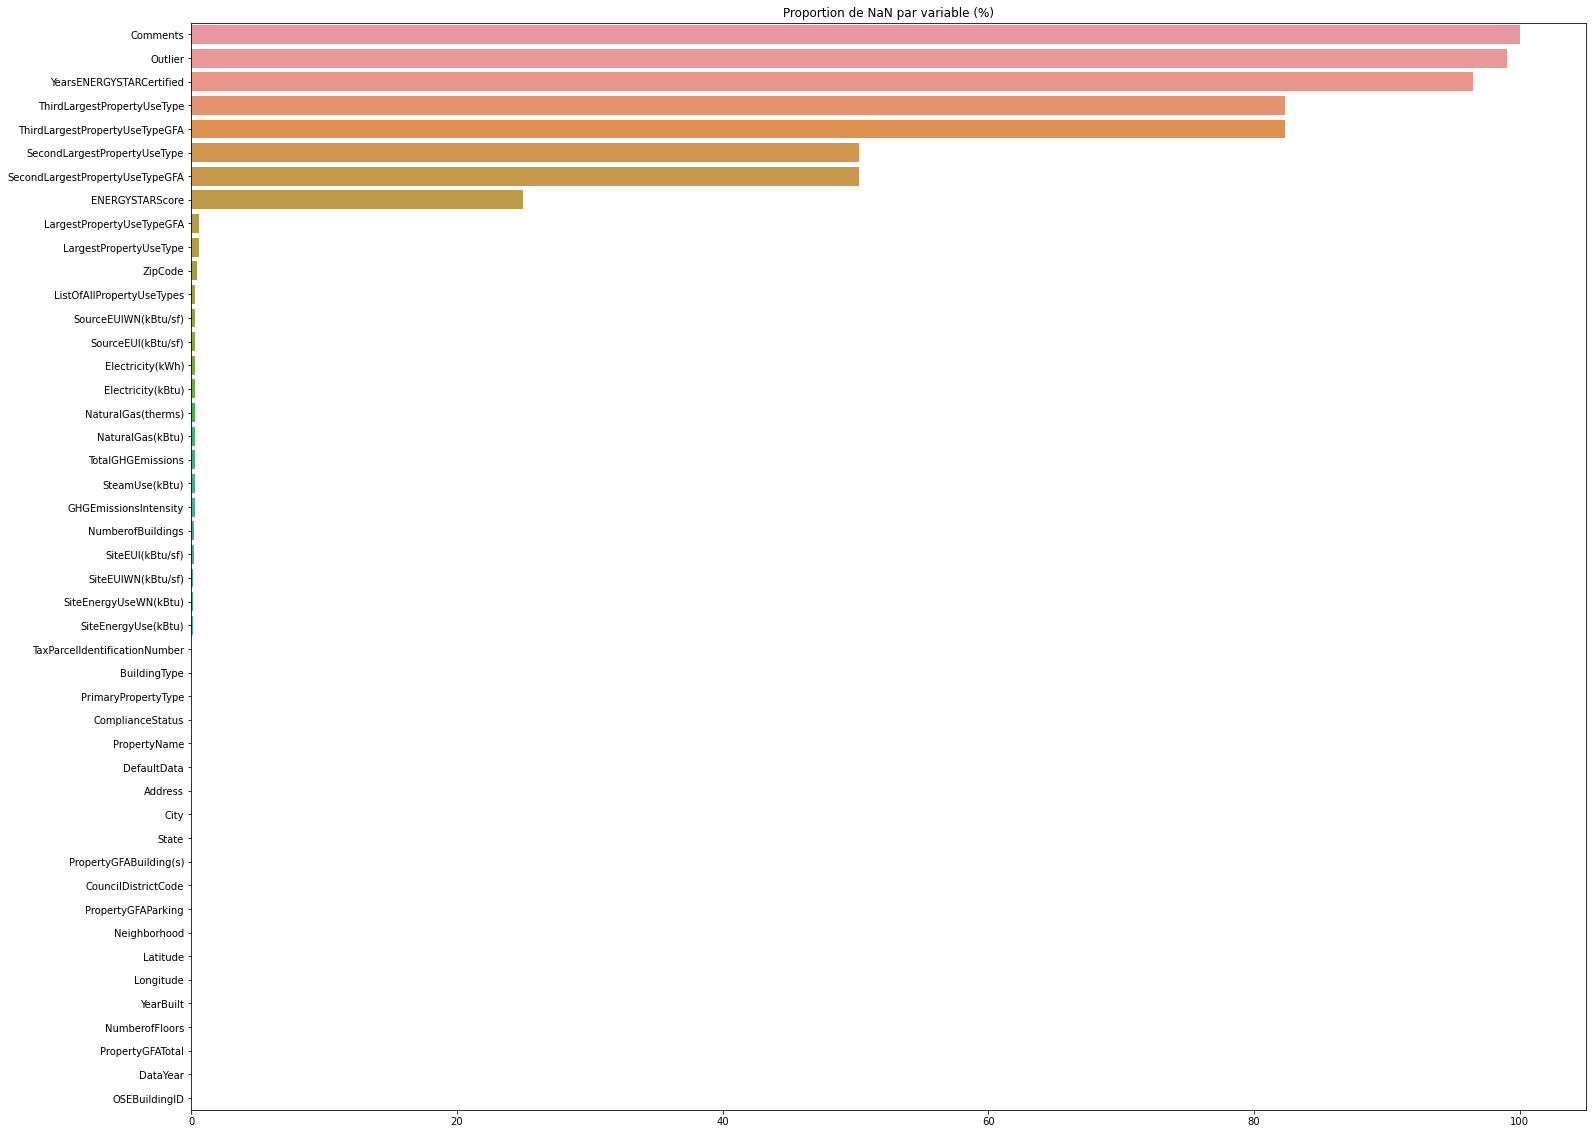

In [11]:
plt.figure(figsize=(25,20))
plt.title('Proportion de NaN par variable (%)')
sns.barplot(x=df_nan.values/data.shape[0]*100, y=df_nan.index)

Text(0.5, 1.0, 'Quantifier les valeurs manquantes')

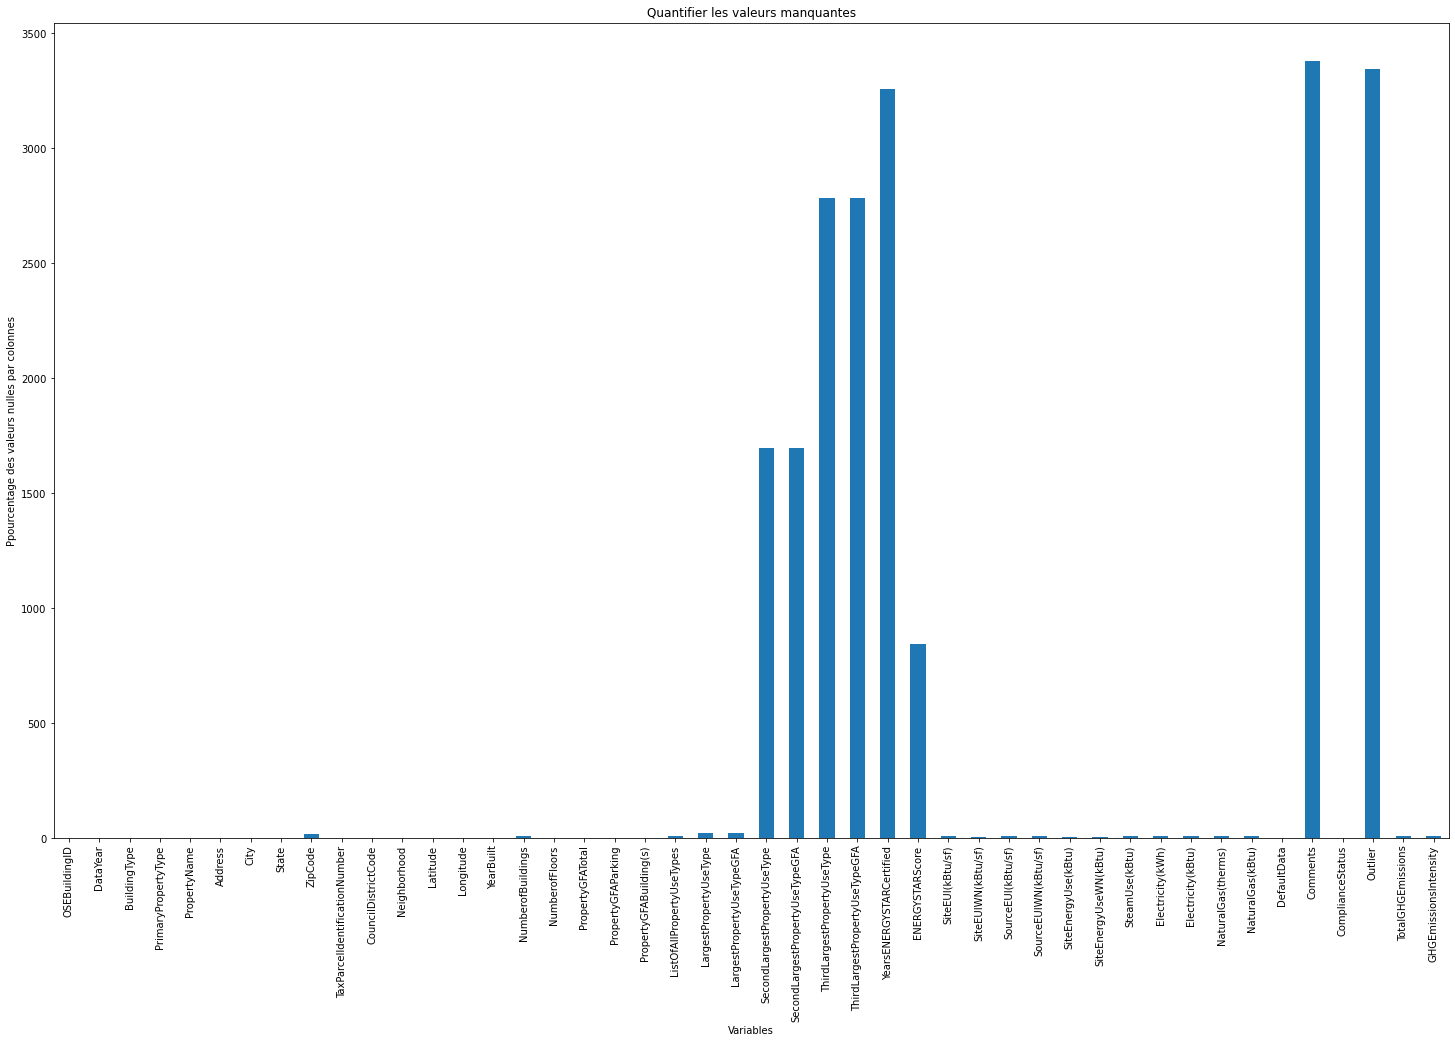

In [12]:
data.isnull().sum().plot.bar(figsize=(25,15))
plt.ylabel('Ppourcentage des valeurs nulles par colonnes')
plt.xlabel('Variables')
plt.title('Quantifier les valeurs manquantes')

## Supprimmer les colonnes sans aucune valeur

In [13]:
data = data.dropna(axis=1, how="all")

In [14]:
data.isnull().mean()

OSEBuildingID                      0.000000
DataYear                           0.000000
BuildingType                       0.000000
PrimaryPropertyType                0.000000
PropertyName                       0.000000
Address                            0.000000
City                               0.000000
State                              0.000000
ZipCode                            0.004739
TaxParcelIdentificationNumber      0.000000
CouncilDistrictCode                0.000000
Neighborhood                       0.000000
Latitude                           0.000000
Longitude                          0.000000
YearBuilt                          0.000000
NumberofBuildings                  0.002370
NumberofFloors                     0.000000
PropertyGFATotal                   0.000000
PropertyGFAParking                 0.000000
PropertyGFABuilding(s)             0.000000
ListOfAllPropertyUseTypes          0.002666
LargestPropertyUseType             0.005924
LargestPropertyUseTypeGFA       

La colonne comments a été supprimé

### Observer les colonnes avec plus de 50% valeurs manquantes 

In [15]:
data[['Outlier', 'YearsENERGYSTARCertified','ThirdLargestPropertyUseTypeGFA','ThirdLargestPropertyUseType']].isnull().mean()*100

Outlier                           99.052133
YearsENERGYSTARCertified          96.475118
ThirdLargestPropertyUseTypeGFA    82.345972
ThirdLargestPropertyUseType       82.345972
dtype: float64

### Filtrer et garder les données de 2016

In [16]:
data['DataYear'].value_counts()

2016    3376
Name: DataYear, dtype: int64

### Garder que la ville de seattle

In [17]:
data['City'].value_counts()

Seattle    3376
Name: City, dtype: int64

# Les colonnes type object

In [18]:
data.select_dtypes(['object']).nunique().sort_values()

City                                1
State                               1
Outlier                             2
ComplianceStatus                    4
BuildingType                        8
Neighborhood                       19
PrimaryPropertyType                24
ThirdLargestPropertyUseType        44
SecondLargestPropertyUseType       50
LargestPropertyUseType             56
YearsENERGYSTARCertified           65
ListOfAllPropertyUseTypes         466
TaxParcelIdentificationNumber    3268
Address                          3354
PropertyName                     3362
dtype: int64

In [19]:
data['Outlier'].value_counts()

Low outlier     23
High outlier     9
Name: Outlier, dtype: int64

In [20]:
dataOutlier = data[data['Outlier'].notna()]
dataOutlier

OSEBuildingID  DataYear          BuildingType  \
226             350      2016        NonResidential   
384             539      2016        NonResidential   
448             608      2016        NonResidential   
517             704      2016        NonResidential   
720           19708      2016  Multifamily HR (10+)   
834           19934      2016  Multifamily LR (1-4)   
839           19967      2016     SPS-District K-12   
962           20367      2016  Multifamily LR (1-4)   
1045          20617      2016        NonResidential   
1229          21315      2016        NonResidential   
1295          21474      2016        NonResidential   
1341          21562      2016  Multifamily LR (1-4)   
1611          22830      2016        NonResidential   
1707          23174      2016  Multifamily LR (1-4)   
1888          23708      2016  Multifamily LR (1-4)   
1945          23912      2016        NonResidential   
2129          24547      2016        NonResidential   
2189          24717      2016        NonResidential   
2216          24825      2016        NonResidential   
2353          25358      2016  Multifamily LR (1-4)   
2410          25553      2016        NonResidential   
2450          25674      2016        NonResidential   
2476          25756      2016  Multifamily LR (1-4)   
2763          26852      2016  Multifamily LR (1-4)   
2801          27007      2016        NonResidential   
2863          27245      2016  Multifamily LR (1-4)   
2922          27526      2016  Multifamily LR (1-4)   
3082          28735      2016  Multifamily LR (1-4)   
3092          29390      2016  Multifamily MR (5-9)   
3152          43948      2016    Nonresidential COS   
3265          49943      2016  Multifamily LR (1-4)   
3341          50071      2016  Multifamily MR (5-9)   

              PrimaryPropertyType                    PropertyName  \
226                  Large Office      Second And Spring Building   
384                  Retail Store               University Center   
448                  Large Office          411 1ST AVE  S (ID608)   
517                  Large Office            401 Elliott Ave West   
720         High-Rise Multifamily                       Bay Vista   
834          Low-Rise Multifamily                   Belmont Lofts   
839                   K-12 School                  Queen Anne Gym   
962          Low-Rise Multifamily           City Lights on Harbor   
1045                 Retail Store           Seattle Habitat Store   
1229  Small- and Mid-Sized Office                 1518 Fifith Ave   
1295                        Other                  The Lusty Lady   
1341         Low-Rise Multifamily           Diplomat Condominiums   
1611             Worship Facility                  Freedom Church   
1707         Mid-Rise Multifamily         Taylor Anne Condominium   
1888         Low-Rise Multifamily           Anne Vista Apartments   
1945  Small- and Mid-Sized Office                  1416 S Jackson   
2129                  K-12 School       Islamic School of Seattle   
2189                        Other        1701 First Ave South LLC   
2216  Small- and Mid-Sized Office                   2233 Building   
2353         Low-Rise Multifamily           One West Condominiums   
2410                        Hotel  J & M HOTEL BUILDING (ID25553)   
2450         Low-Rise Multifamily          (ID25674) COMET TAVERN   
2476         Low-Rise Multifamily       West Olympic Condominiums   
2763         Low-Rise Multifamily                  Atlas Building   
2801             Worship Facility        Seattle Community Church   
2863         Low-Rise Multifamily            St. Johns Apartments   
2922         Low-Rise Multifamily                        Vali Hai   
3082         Low-Rise Multifamily                      Building 4   
3092         Mid-Rise Multifamily    Commodore Duchess Apartments   
3152                        Other           Georgetown Steamplant   
3265         Low-Rise Multifamily                  

In [21]:
data.shape

(3376, 45)

## Garder les propriétées sans high ou low outliers

In [22]:
filtered_data = data[data['Outlier'].isna()]

In [23]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3344 entries, 0 to 3375
Data columns (total 45 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3344 non-null   int64  
 1   DataYear                         3344 non-null   int64  
 2   BuildingType                     3344 non-null   object 
 3   PrimaryPropertyType              3344 non-null   object 
 4   PropertyName                     3344 non-null   object 
 5   Address                          3344 non-null   object 
 6   City                             3344 non-null   object 
 7   State                            3344 non-null   object 
 8   ZipCode                          3328 non-null   float64
 9   TaxParcelIdentificationNumber    3344 non-null   object 
 10  CouncilDistrictCode              3344 non-null   int64  
 11  Neighborhood                     3344 non-null   object 
 12  Latitude            

In [24]:
data.shape

(3376, 45)

## Visualiser les variables

### variable numerique 

In [25]:
data_float = filtered_data.drop(['GHGEmissionsIntensity','TotalGHGEmissions','DataYear'], axis = 1).select_dtypes('int64','float64')

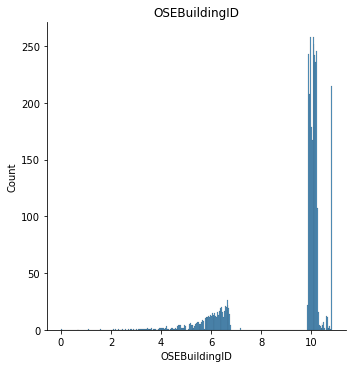

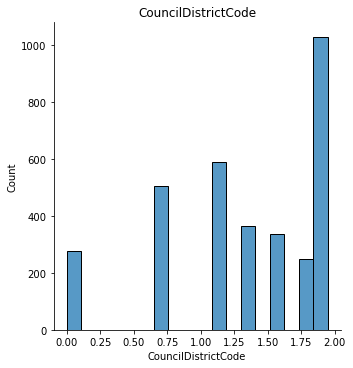

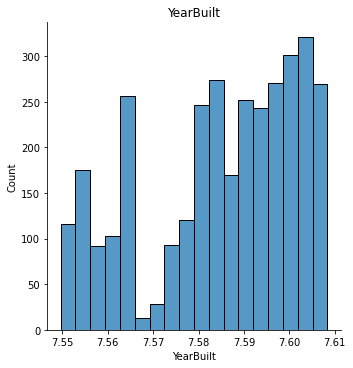

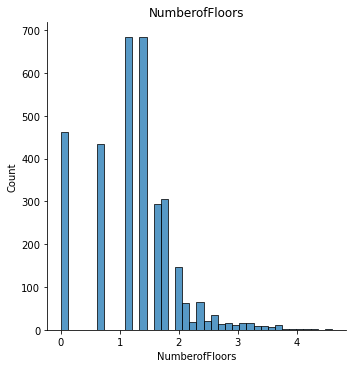

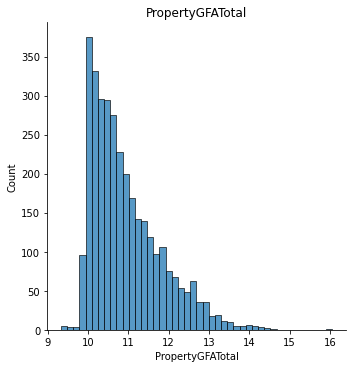

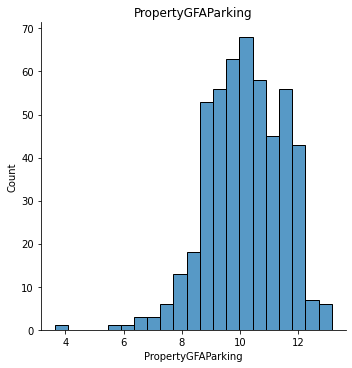

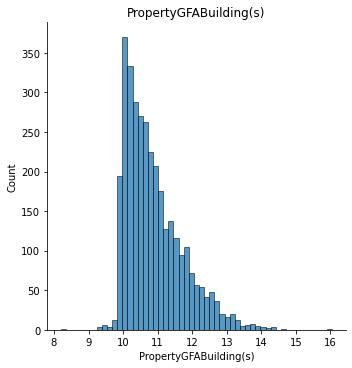

In [26]:
for col in data_float:
    sns.displot(data=np.log(data_float[data_float[col]>0][col]))
    plt.title(col)
    plt.show()

<Figure size 864x432 with 0 Axes>

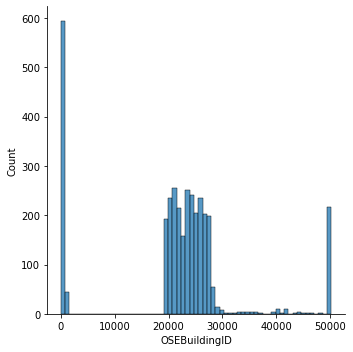

<Figure size 864x432 with 0 Axes>

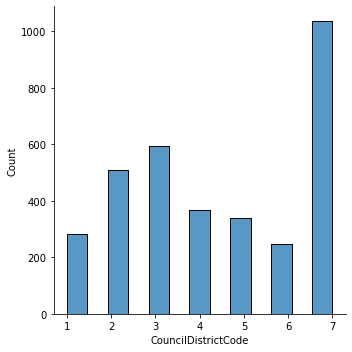

<Figure size 864x432 with 0 Axes>

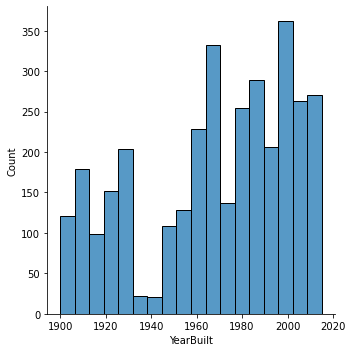

<Figure size 864x432 with 0 Axes>

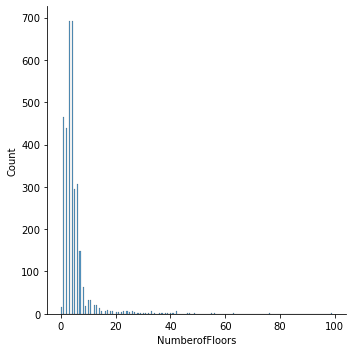

<Figure size 864x432 with 0 Axes>

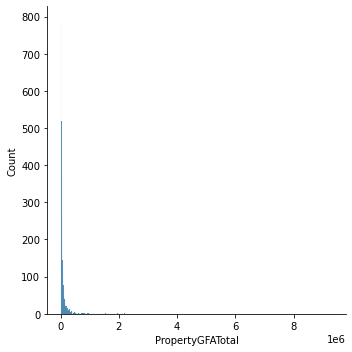

<Figure size 864x432 with 0 Axes>

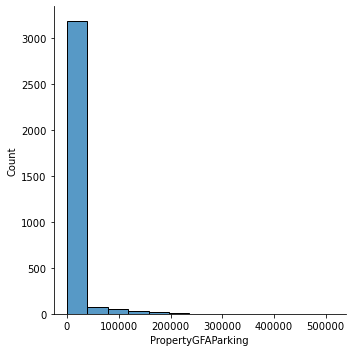

<Figure size 864x432 with 0 Axes>

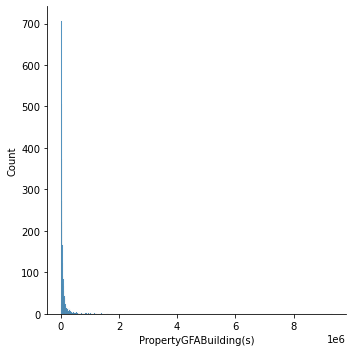

In [27]:
for col in data_float:
    plt.figure(figsize=(12,6))
    
    sns.displot(data=data[col])

### Variable categorielle

Text(0.5, 1.0, 'Type de bâtiment\n')

<Figure size 864x576 with 0 Axes>

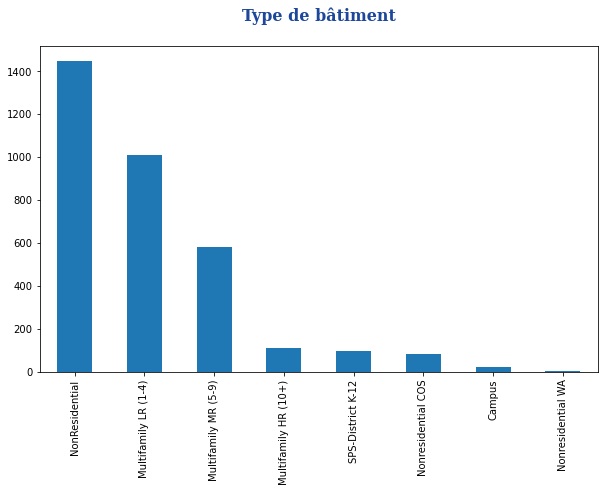

In [28]:

font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

fig = plt.figure(figsize=(12,8))
plt.figure(figsize=(10,6))
filtered_data["BuildingType"].value_counts().plot(kind = 'bar')
plt.title(f"Type de bâtiment\n", 
          fontdict=font_title, fontsize=16)

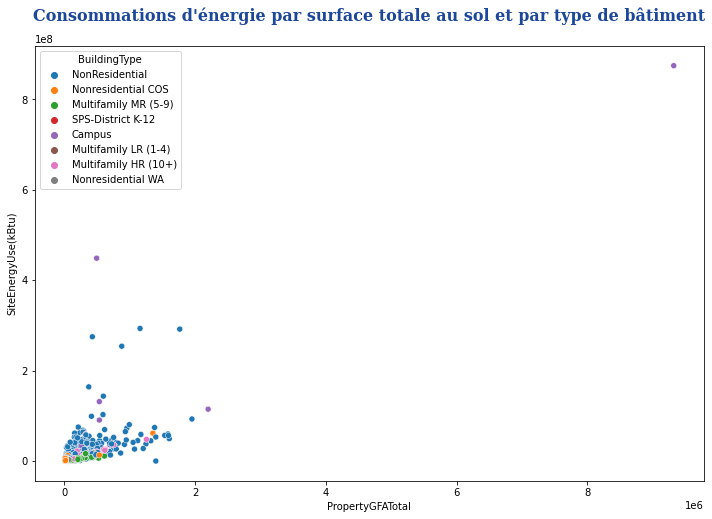

In [29]:
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = filtered_data, x='PropertyGFATotal', y='SiteEnergyUse(kBtu)', hue='BuildingType')
plt.title(f"Consommations d'énergie par surface totale au sol et par type de bâtiment\n", 
          fontdict=font_title, fontsize=16)
plt.show()

<AxesSubplot:>

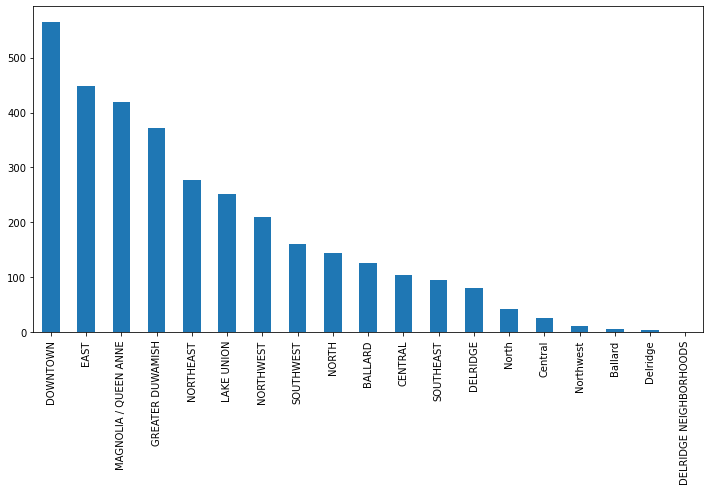

In [30]:
plt.figure(figsize=(12,6))
filtered_data["Neighborhood"].value_counts().plot(kind = 'bar')

<AxesSubplot:>

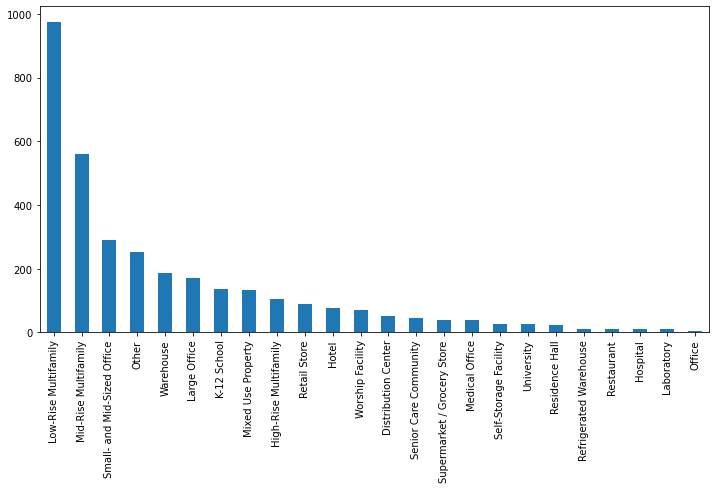

In [31]:
plt.figure(figsize= (12,6))
filtered_data['PrimaryPropertyType'].value_counts().plot(kind = 'bar')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:>

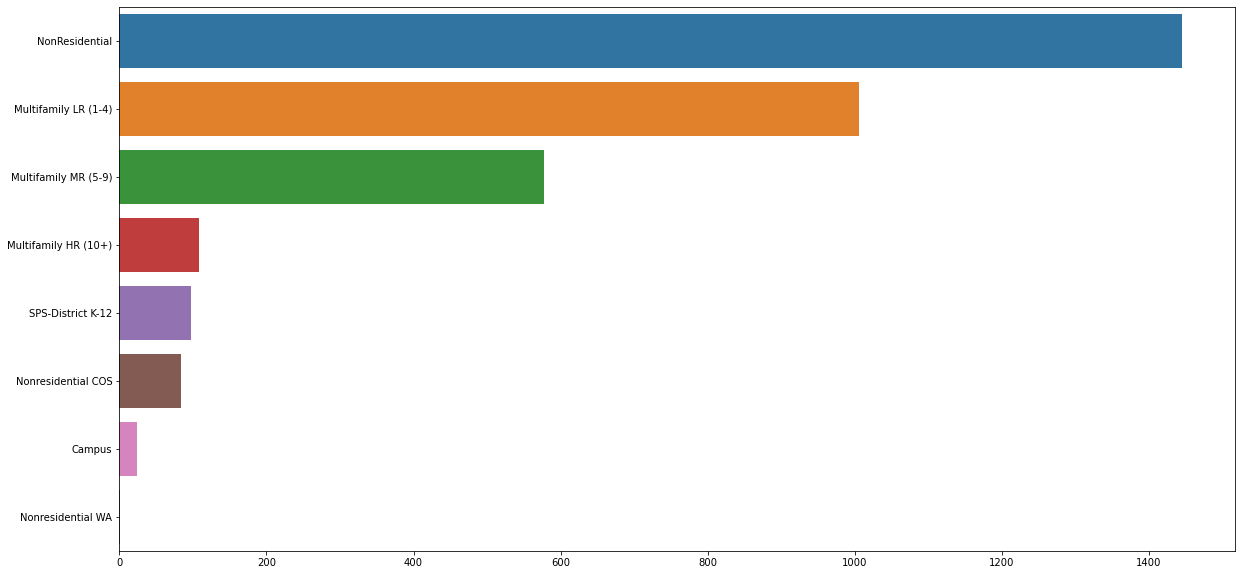

In [32]:
plt.figure(1, figsize=(20 ,10))
sns.barplot(filtered_data['BuildingType'].value_counts().values,filtered_data['BuildingType'].value_counts().index)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:>

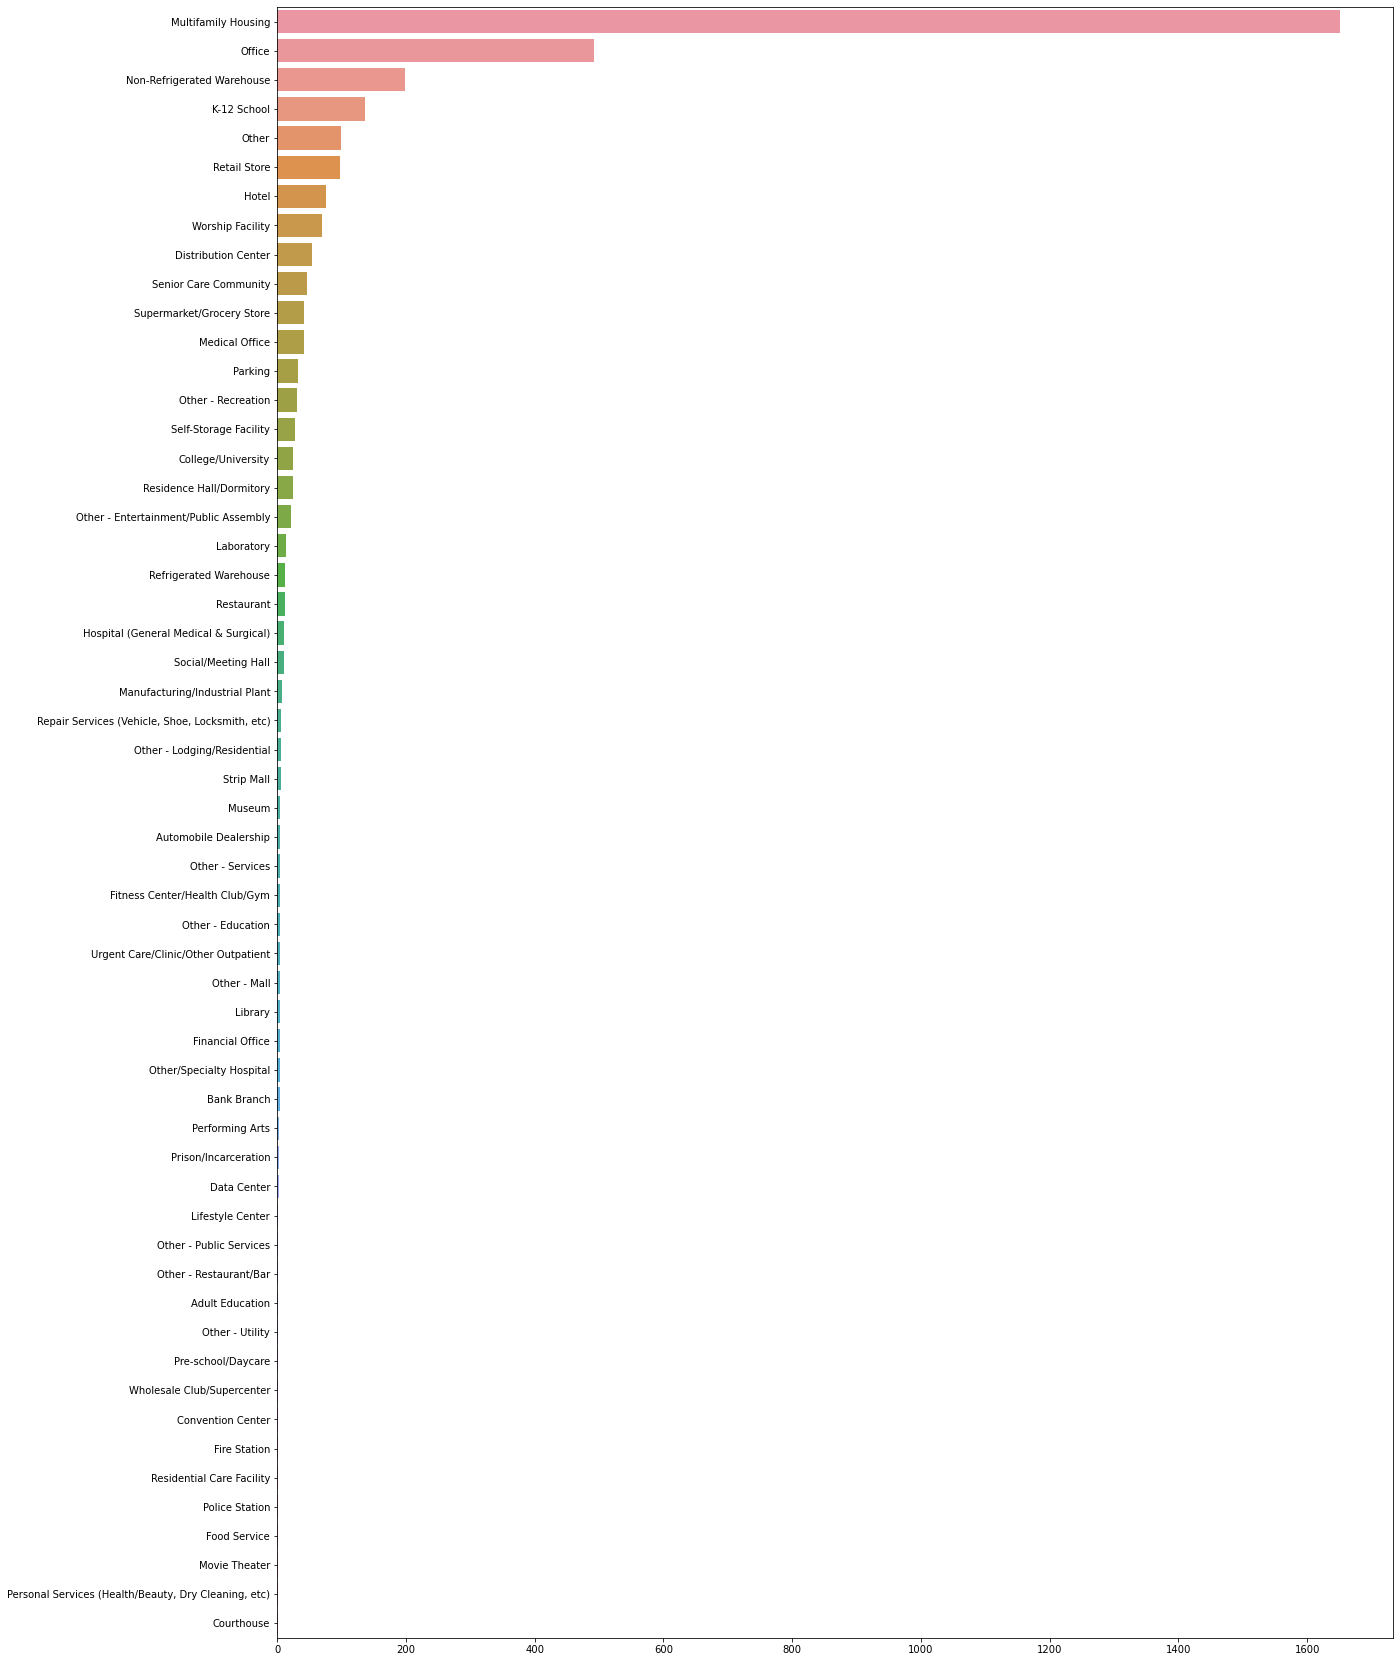

In [33]:
plt.figure(1, figsize=(20 ,30))
sns.barplot(filtered_data['LargestPropertyUseType'].value_counts().values,filtered_data['LargestPropertyUseType'].value_counts().index)

## Garder que les propriétées non destinées a l'habitation

Dans le projet que seuls les bâtiments non destinés à l'habitation seront étudiés. Nous allons donc supprimer toutes les lignes correspondant à des habitations en nous basant sur la variable BuildingType

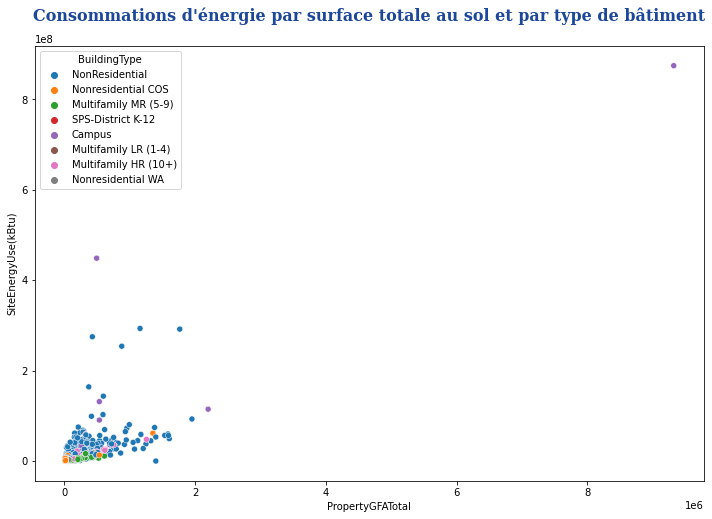

In [34]:
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = filtered_data, x='PropertyGFATotal', y='SiteEnergyUse(kBtu)', hue='BuildingType')
plt.title(f"Consommations d'énergie par surface totale au sol et par type de bâtiment\n", 
          fontdict=font_title, fontsize=16)
plt.show()

In [35]:
filtered_data["BuildingType"].value_counts()

NonResidential          1445
Multifamily LR (1-4)    1006
Multifamily MR (5-9)     578
Multifamily HR (10+)     109
SPS-District K-12         97
Nonresidential COS        84
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64

Le bâtiment de type campus est très supérieur aux autres données. Il ne s'agit sans doute pas d'une valeur abérrante mais d'une valeur atypique qui est très isolée.   
Nous allons supprimer de nos données ces valeurs ainsi que les batiment multifamily qui correspondent des habitation destinées a des familles 

In [36]:
# Liste des valeurs à filtrer et supprimer

value_remove =[ "Multifamily LR (1-4)", "Multifamily MR (5-9)" ,"Multifamily HR (10+)","Campus"]

In [37]:
# Filtrer et supprimer les valeurs 
filtered = filtered_data[~filtered_data['BuildingType'].isin(value_remove)]

In [38]:
filtered['BuildingType'].value_counts()

NonResidential        1445
SPS-District K-12       97
Nonresidential COS      84
Nonresidential WA        1
Name: BuildingType, dtype: int64

<AxesSubplot:>

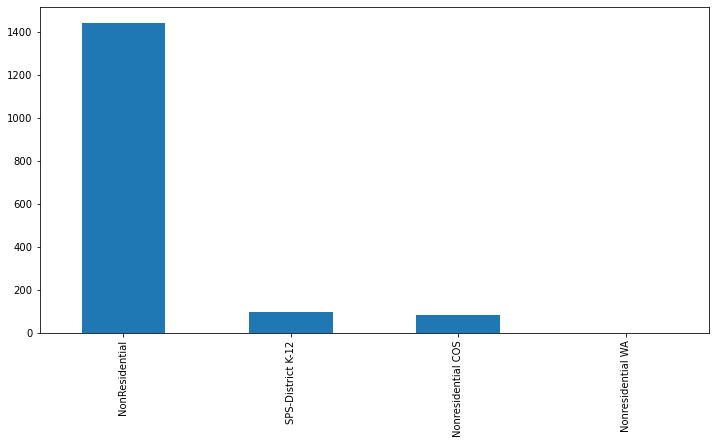

In [39]:
plt.figure(figsize= (12,6))
filtered['BuildingType'].value_counts().plot(kind = 'bar')

In [40]:
filtered.isnull().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                              16
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     2
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             2
LargestPropertyUseType                6
LargestPropertyUseTypeGFA             6
SecondLargestPropertyUseType        790
SecondLargestPropertyUseTypeGFA     790


## ComplianceStatus

In [41]:
filtered['ComplianceStatus'].value_counts()

Compliant                       1524
Error - Correct Default Data      86
Missing Data                      14
Non-Compliant                      3
Name: ComplianceStatus, dtype: int64

Text(0.5, 1.0, ' Etat de conformité des données \n')

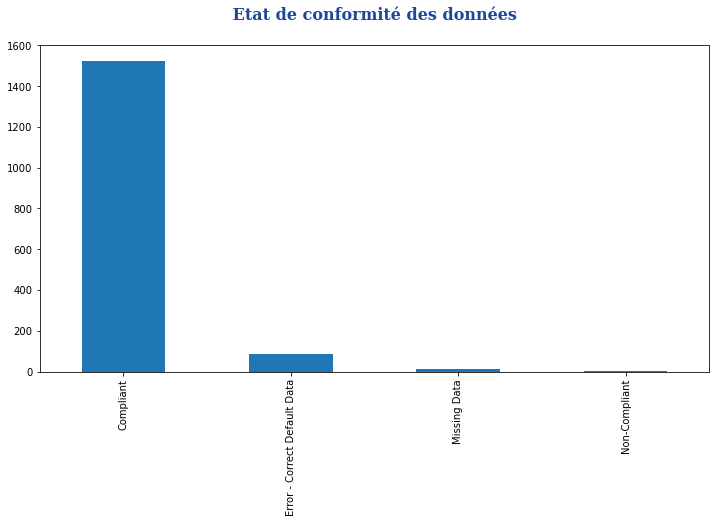

In [42]:
plt.figure(figsize= (12,6))
filtered['ComplianceStatus'].value_counts().plot(kind = 'bar')
plt.title(f" Etat de conformité des données \n", 
          fontdict=font_title, fontsize=16)


Nous allons conserver que les Données conforme(compliant)  correspondent aux données conformes.


In [43]:
# Liste des valeurs à filtrer et supprimer

to_remove =[ "Error - Correct Default Data", "Missing Data" ,"Non-Compliant"]

In [44]:
# Filtrer et supprimer les valeurs 
filtered = filtered[~filtered['ComplianceStatus'].isin(to_remove)]

In [45]:
filtered['ComplianceStatus'].value_counts()

Compliant    1524
Name: ComplianceStatus, dtype: int64

### Colonne YearBuilt

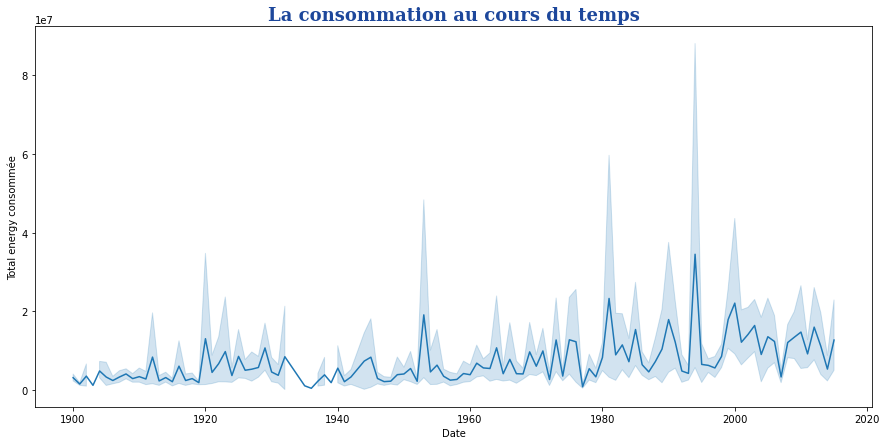

In [46]:
plt.figure(figsize=(15,7))
sns.lineplot(data=filtered, x="YearBuilt", y="SiteEnergyUseWN(kBtu)")

# Ajouter des étiquettes et un titre
plt.xlabel("Date")
plt.ylabel("Total energy consommée")
plt.title("La consommation au cours du temps", fontdict=font_title)

# Afficher le graphique
plt.show()

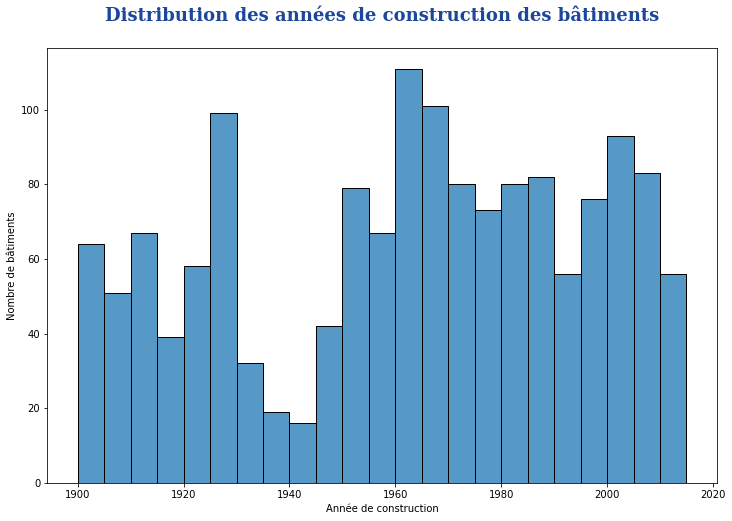

In [47]:
fig = plt.figure(figsize=(12,8))
ax = sns.histplot(data=filtered, x='YearBuilt', bins=int((filtered.YearBuilt.max() - filtered.YearBuilt.min())/5))
ax.set_xlabel("Année de construction")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Distribution des années de construction des bâtiments\n", fontdict=font_title)
plt.show()

Nois observons que pendant la periode creuse avecc un faible tot de construction , peut etre expliqué par la période de  
la deuxiéme guerre mondial

### Colonne neighborhood

In [48]:
import branca
import folium

## Observer la geolocalisation des  batiments par années de constructions

In [49]:

map_osm = folium.Map()
map_osm = folium.Map(location=[filtered['Latitude'].mean(), filtered['Longitude'].mean()],zoom_start=11)
#for i in range(0,len(filtered)):
   # folium.Circle([filtered.iloc[i]['Latitude'],filtered.iloc[i]['Longitude']], 
                     # popup=filtered.iloc[i]['Address'], radius =100).add_to(map_osm)

In [50]:
# Définir une palette de couleurs
def color_producer(year):
    min_year = np.min(filtered['YearBuilt'])  # Supposons que 'year' est le nom de la colonne avec l'année de construction
    max_year = np.max(filtered['YearBuilt'])
    interval = max_year - min_year
    return f'#{int(255 * (year - min_year) / interval):02x}{int(255 * (1 - (year - min_year) / interval)):02x}00'


In [51]:
for i in range(0, len(filtered)):
    folium.Circle(
        location=[filtered.iloc[i]['Latitude'], filtered.iloc[i]['Longitude']], 
        popup=filtered.iloc[i]['Neighborhood'],
        radius=100,
        color=color_producer(filtered.iloc[i]['YearBuilt']),
        fill=True,
        fill_opacity=0.6
    ).add_to(map_osm)

In [52]:
colorscale = branca.colormap.linear.YlOrRd_09.scale(np.min(filtered['YearBuilt']), np.max(filtered['YearBuilt']))
colorscale = colorscale.to_step(index=[year for year in range(int(np.min(filtered['YearBuilt'])), int(np.max(filtered['YearBuilt'])) + 1)])
colorscale.caption = 'Année de construction'
map_osm.add_child(colorscale)

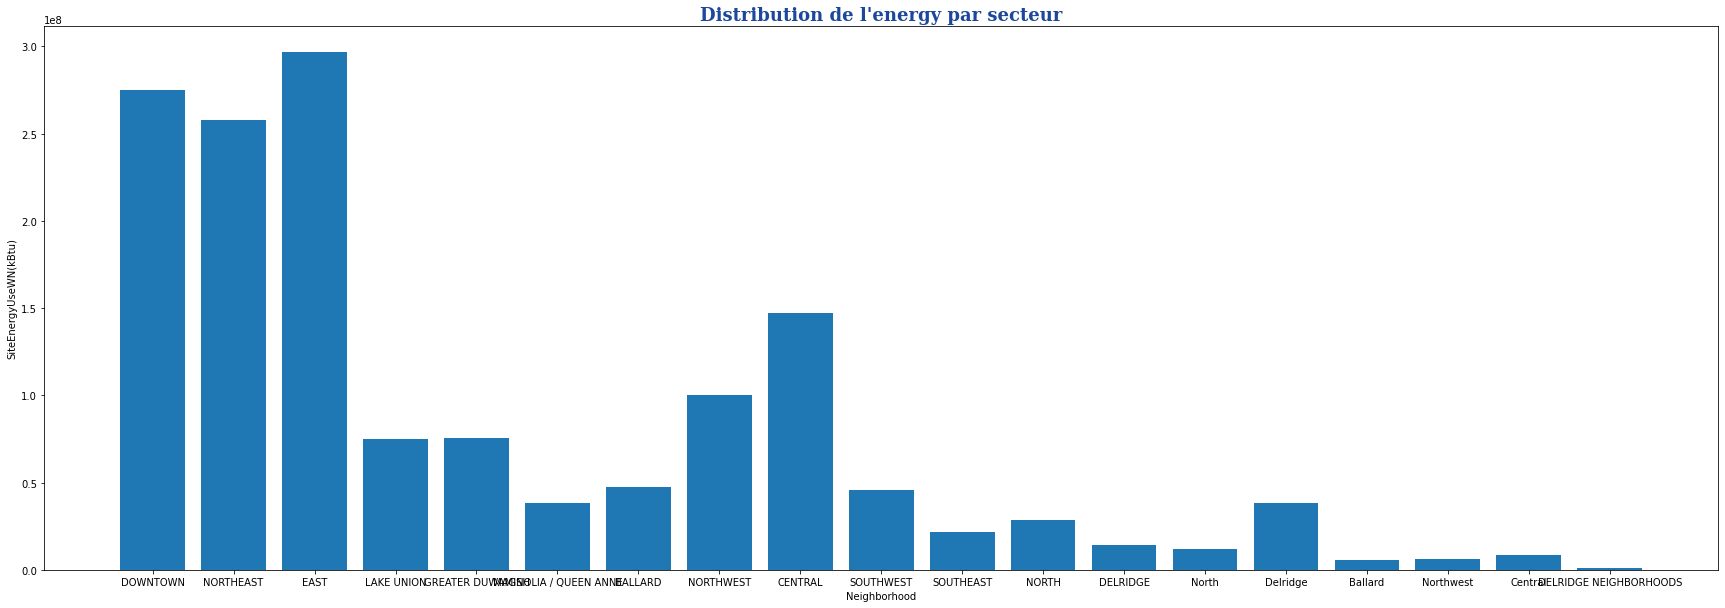

In [53]:
plt.figure(figsize = (30,10))
plt.bar(filtered['Neighborhood'],filtered['SiteEnergyUseWN(kBtu)'])
plt.xlabel('Neighborhood')
plt.ylabel('SiteEnergyUseWN(kBtu)')
plt.title("Distribution de l'energy par secteur",fontdict=font_title )

# Afficher le scatter plot
plt.show()

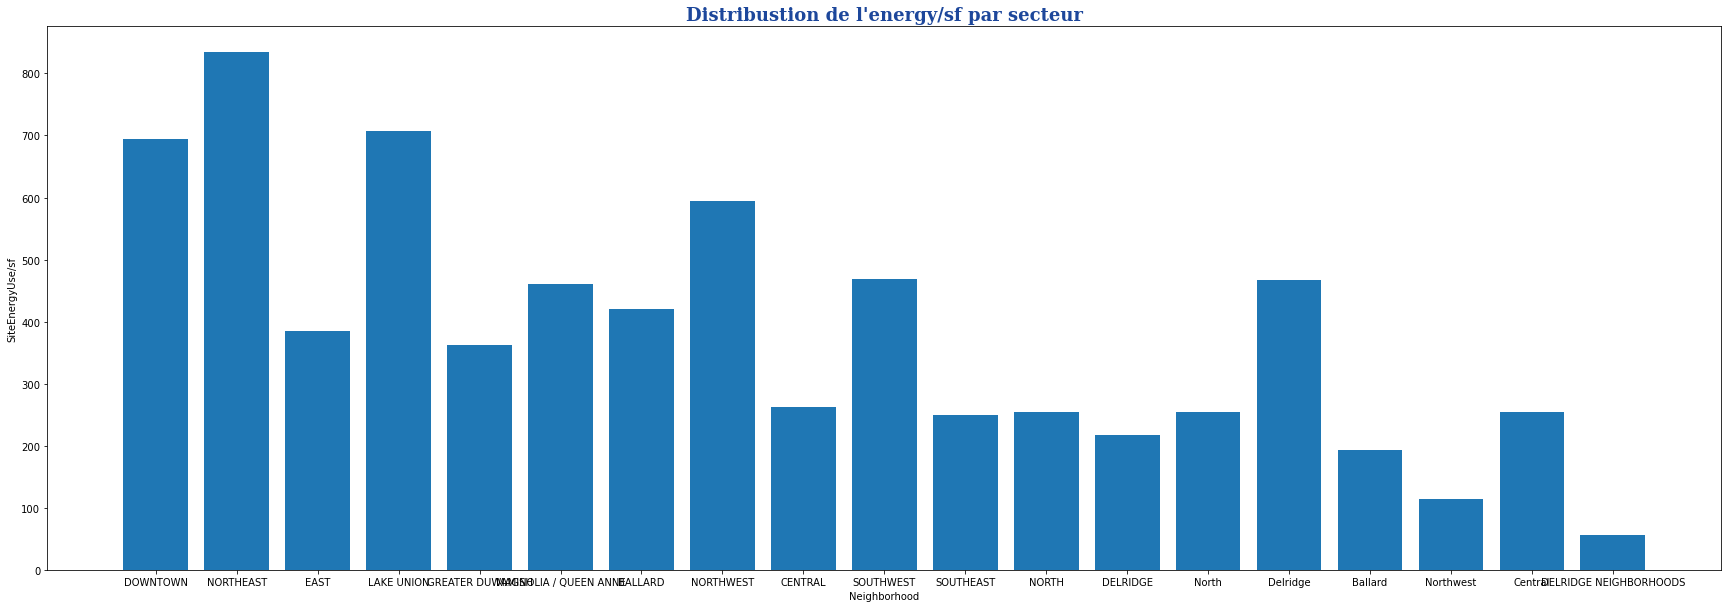

In [54]:
plt.figure(figsize = (30,10))
plt.bar(filtered['Neighborhood'],filtered['SiteEUIWN(kBtu/sf)'])
plt.xlabel('Neighborhood')
plt.ylabel('SiteEnergyUse/sf')
plt.title("Distribustion de l'energy/sf par secteur",fontdict=font_title)

# Afficher le scatter plot
plt.show()

### Colonne PrimaryPropertyType

In [55]:
filtered['PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    286
Other                          238
Warehouse                      185
Large Office                   168
Mixed Use Property             109
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             53
K-12 School                     46
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           20
University                      18
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             1
Name: PrimaryPropertyType, dtype: int64

### regarder les valeurs nulles

In [56]:
filtered.isna().sum().sort_values(ascending= False)

Outlier                            1524
YearsENERGYSTARCertified           1427
ThirdLargestPropertyUseType        1183
ThirdLargestPropertyUseTypeGFA     1183
SecondLargestPropertyUseType        693
SecondLargestPropertyUseTypeGFA     693
ENERGYSTARScore                     532
ZipCode                              13
LargestPropertyUseType                4
LargestPropertyUseTypeGFA             4
SiteEUIWN(kBtu/sf)                    1
SiteEnergyUseWN(kBtu)                 1
Electricity(kWh)                      0
SteamUse(kBtu)                        0
Electricity(kBtu)                     0
SiteEnergyUse(kBtu)                   0
SourceEUIWN(kBtu/sf)                  0
SourceEUI(kBtu/sf)                    0
SiteEUI(kBtu/sf)                      0
NaturalGas(therms)                    0
NaturalGas(kBtu)                      0
DefaultData                           0
ComplianceStatus                      0
TotalGHGEmissions                     0
OSEBuildingID                         0


### Colonnes surface : 

In [57]:
# Trouver toutes les colonnes contenant 'GFA'
gfa_columns = [col for col in filtered.columns if 'GFA' in col]

# Afficher la liste des colonnes
print(gfa_columns)

['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']


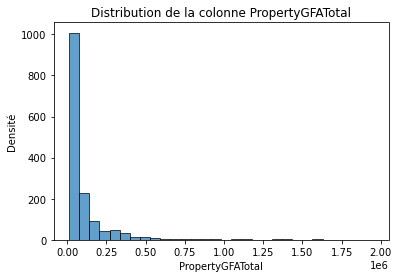

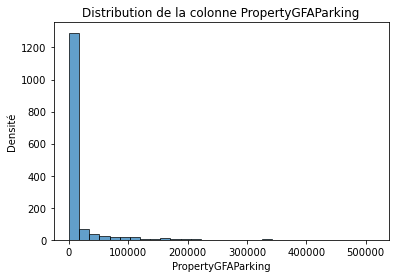

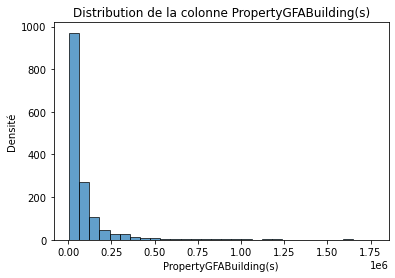

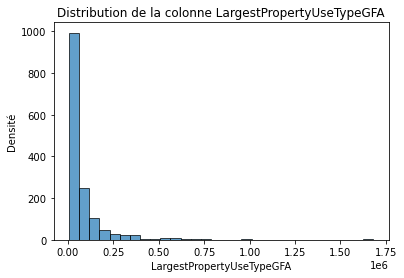

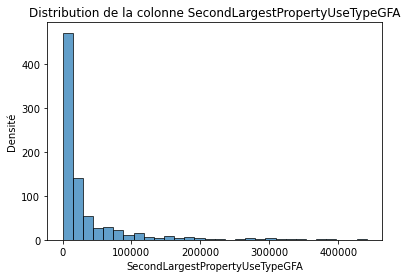

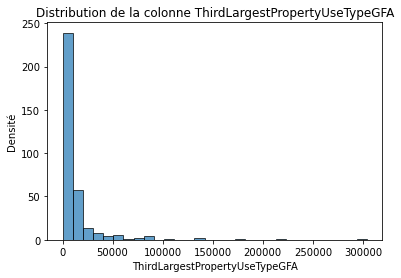

In [58]:
for col in gfa_columns:
    plt.hist(filtered[col], bins = 30, edgecolor = 'k', alpha = 0.7)
    plt.title(f"Distribution de la colonne {col}")
    plt.xlabel(col)
    plt.ylabel("Densité")
    plt.show()

In [59]:
# Affichage des statistiques pour chaque colonne de la liste
for col in gfa_columns:
    print(f"Statistiques pour la colonne {col}:\n")
    print(filtered[col].describe())
    print("\n" + "-"*50 + "\n")


Statistiques pour la colonne PropertyGFATotal:

count    1.524000e+03
mean     1.125095e+05
std      1.900303e+05
min      1.128500e+04
25%      2.880600e+04
50%      4.797750e+04
75%      1.039332e+05
max      1.952220e+06
Name: PropertyGFATotal, dtype: float64

--------------------------------------------------

Statistiques pour la colonne PropertyGFAParking:

count      1524.000000
mean      13966.167323
std       43959.603055
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      512608.000000
Name: PropertyGFAParking, dtype: float64

--------------------------------------------------

Statistiques pour la colonne PropertyGFABuilding(s):

count    1.524000e+03
mean     9.854330e+04
std      1.662346e+05
min      3.636000e+03
25%      2.786650e+04
50%      4.579250e+04
75%      9.383225e+04
max      1.765970e+06
Name: PropertyGFABuilding(s), dtype: float64

--------------------------------------------------

Statistiques pour la colonne

Nous n'avons pas de valeurs negatives , toutes les distributions des des variables surfaces sont biaisée à gauche
Pour certaines colonnes la presence d'un grand pourcentages de valeurs nulles(zero) , exemple de la surface de parking avec  une median et une moyenne  a 0.

In [60]:
def check_column_addition(df, col1, col2, result_col):
  
  #Retourne les lignes pour lesquelles la somme des deux colonnes ne correspond pas au total
 

    return df[df[col1] + df[col2] != df[result_col]]

In [61]:
check_column_addition(filtered, 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'PropertyGFATotal')

Empty DataFrame
Columns: [OSEBuildingID, DataYear, BuildingType, PrimaryPropertyType, PropertyName, Address, City, State, ZipCode, TaxParcelIdentificationNumber, CouncilDistrictCode, Neighborhood, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, YearsENERGYSTARCertified, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), SteamUse(kBtu), Electricity(kWh), Electricity(kBtu), NaturalGas(therms), NaturalGas(kBtu), DefaultData, ComplianceStatus, Outlier, TotalGHGEmissions, GHGEmissionsIntensity]
Index: []

In [62]:
gfa_columns

['PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA']

In [63]:
def check_three_column_addition(df, col1, col2,col3, result_col):
  
  #Retourne les lignes pour lesquelles la somme des trois colonnes soit supérieur pas au total
 

    return df[df[col1] + df[col2] + df[col3] > df[result_col]]

In [64]:
colonnes_superieur = check_three_column_addition(filtered,'ThirdLargestPropertyUseTypeGFA','LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','PropertyGFATotal')

In [65]:
colonnes_superieur

OSEBuildingID  DataYear        BuildingType PrimaryPropertyType  \
4                 8      2016      NonResidential               Hotel   
15               21      2016  Nonresidential COS               Other   
16               22      2016      NonResidential               Other   
26               32      2016      NonResidential               Hotel   
36               46      2016      NonResidential           Warehouse   
...             ...       ...                 ...                 ...   
3162          49695      2016      NonResidential        Large Office   
3199          49776      2016      NonResidential        Large Office   
3221          49802      2016      NonResidential               Hotel   
3329          50054      2016  Nonresidential COS        Large Office   
3337          50062      2016      NonResidential               Hotel   

                                      PropertyName               Address  \
4                      WARWICK SEATTLE HOTEL (ID8)         401 LENORA ST   
15    The Seattle Public Library - Central Library    1000 Fourth Avenue   
16                           Downtown Seattle YMCA        909 4th Avenue   
26                                 Homewood Suites          1011 Pike ST   
36                                   Seattle 11-13     3301 S NORFOLK ST   
...                                            ...                   ...   
3162                           City Place V - SEDO  207 Boren Ave. North   
3199                            Market Place Tower       2025 1st Avenue   
3221                                 Hotel Ballard   5216 Ballard Ave NW   
3329                      400 FAIRVIEW OFFICE BLDG    400 FAIRVIEW AVE N   
3337                           Olympic Hospitality     3926 Aurora Ave N   

         City State  ZipCode TaxParcelIdentificationNumber  \
4     Seattle    WA  98121.0                    0659000970   
15    Seattle    WA  98154.0                    0942000275   
16    Seattle    WA  98104.0                    0942000350   
26    Seattle    WA  98101.0                    0660001832   
36    Seattle    WA  98118.0                    0323049024   
...       ...   ...      ...                           ...   
3162  Seattle    WA  98109.0                    1986200350   
3199  Seattle    WA  98121.0                    1977200471   
3221  Seattle    WA  98107.0                    2767702985   
3329  Seattle    WA  98109.0                    2467400120   
3337  Seattle    WA  98103.0                    1931300480   

      CouncilDistrictCode      Neighborhood  Latitude  Longitude  YearBuilt  \
4                       7          DOWNTOWN  47.61375 -122.34047       1980   
15                      7          DOWNTOWN  47.60649 -122.33297       2004   
16                      7          DOWNTOWN  47.60546 -122.33279       1930   
26                      7              EAST  47.61301 -122.32929       1991   
36                      2  GREATER DUWAMISH  47.51138 -122.28875       1961   
...                   ...               ...       ...        ...        ...   
3162                    7        LAKE UNION  47.62037 -122.33627       2012   
3199                    7          DOWNTOWN  47.61156 -122.34401       1988   
3221                    6           BALLARD  47.66629 -122.38260       2013   
3329                    7        LAKE UNION  47.62251 -122.33390       2014   
3337                    4        LAKE UNION  47.65476 -122.34732       2014   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
4                   1.0              18            175580               62000   
15                  1.0              11            412000               57000   
16                  1.0               6            103911                   0   
26                  1.0               8            158676               30301   
36                  3.0               2            714095                   0   
...                 ...             

Nous allons supprimer ces valeurs de notre dataset

In [66]:
filtered.drop(colonnes_superieur.index, inplace = True)

### Vérifier les résultas

In [67]:
check_three_column_addition(filtered,'ThirdLargestPropertyUseTypeGFA','LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','PropertyGFATotal')

Empty DataFrame
Columns: [OSEBuildingID, DataYear, BuildingType, PrimaryPropertyType, PropertyName, Address, City, State, ZipCode, TaxParcelIdentificationNumber, CouncilDistrictCode, Neighborhood, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, YearsENERGYSTARCertified, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), SteamUse(kBtu), Electricity(kWh), Electricity(kBtu), NaturalGas(therms), NaturalGas(kBtu), DefaultData, ComplianceStatus, Outlier, TotalGHGEmissions, GHGEmissionsIntensity]
Index: []

## Nombre de batiment

Text(0.5, 1.0, 'Nmbre de batiment par proprietée')

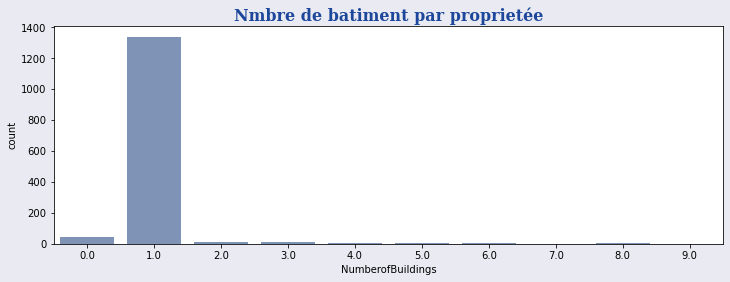

In [68]:
plt.figure(figsize=(12,4), facecolor="#eaeaf2")
sns.countplot(data=filtered, x='NumberofBuildings', color='#7490c0');
plt.title("Nmbre de batiment par proprietée", 
          fontdict=font_title, fontsize=16)

Ne conservez que des propriétés avec un seul bâtiment.

## Le type de batiment

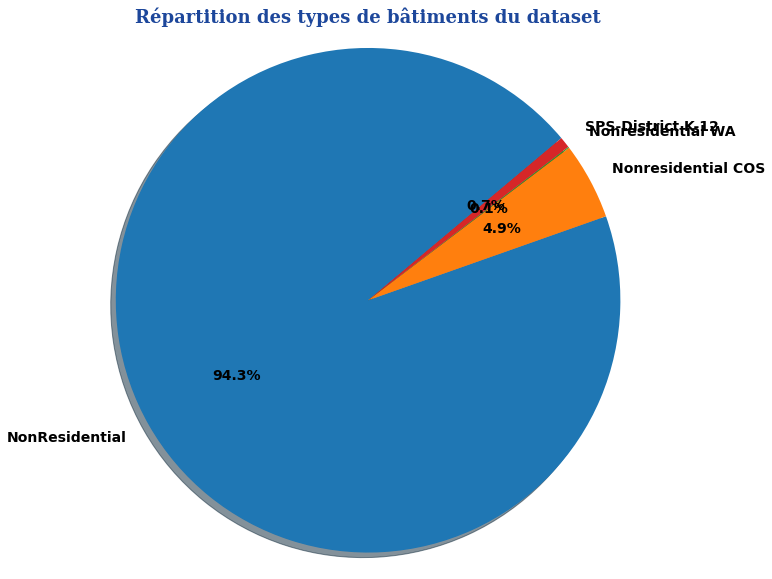

In [69]:
building_type = filtered.groupby(by='BuildingType')['OSEBuildingID'].nunique()
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

fig, ax = plt.subplots(figsize=(10,10))
ax.pie(building_type.values, labels=building_type.index, 
       autopct='%1.1f%%', shadow=True, startangle=40,
       textprops=dict(color="black",size=14, weight="bold"))
ax.axis('equal')
ax.set_title("Répartition des types de bâtiments du dataset", fontdict=font_title)
plt.show()

### Regarder les batiments NonResidential

In [70]:
filtered.loc[(filtered['BuildingType']=="NonResidential"),'PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    272
Other                          175
Warehouse                      174
Large Office                   136
Retail Store                    84
Mixed Use Property              73
Worship Facility                68
Hotel                           67
Distribution Center             51
Supermarket / Grocery Store     38
K-12 School                     37
Medical Office                  36
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           19
University                      17
Refrigerated Warehouse          12
Hospital                        10
Restaurant                      10
Laboratory                       9
Low-Rise Multifamily             1
Name: PrimaryPropertyType, dtype: int64

La categorie : Bureaux de petite et moyenne taille ,Autre, Entrepôt, Grand bureau represente la plus grande  
partie de Non resential

## 1. La target SiteEnergy



 **SiteEnergyUseWN(kBtu)** (La quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie)  

In [71]:
filtered['SiteEnergyUseWN(kBtu)'].isnull().sum()

1

supprimer la valeur nulle dans la taget

In [72]:
filtered = filtered.dropna( subset = 'SiteEnergyUseWN(kBtu)')

In [73]:
filtered['SiteEnergyUseWN(kBtu)'].isnull().sum()

0

In [74]:
filtered['SiteEnergyUseWN(kBtu)'].describe()

count    1.418000e+03
mean     7.214231e+06
std      1.864833e+07
min      0.000000e+00
25%      1.269811e+06
50%      2.624397e+06
75%      6.652132e+06
max      2.966717e+08
Name: SiteEnergyUseWN(kBtu), dtype: float64

Nous n'avons pas de valeurs négative pour cette target

divide by zero encountered in log


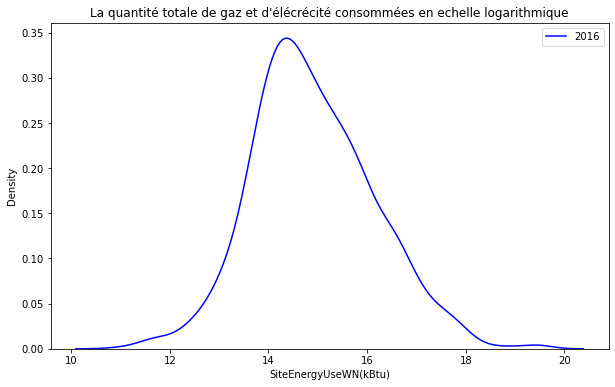

In [75]:
plt.figure(figsize=(10,6))
plt.title("La quantité totale de gaz et d'élécrécité consommées en echelle logarithmique")
sns.kdeplot(np.log(filtered['SiteEnergyUseWN(kBtu)']), label='2016', color= 'blue')

plt.legend()
plt.show()

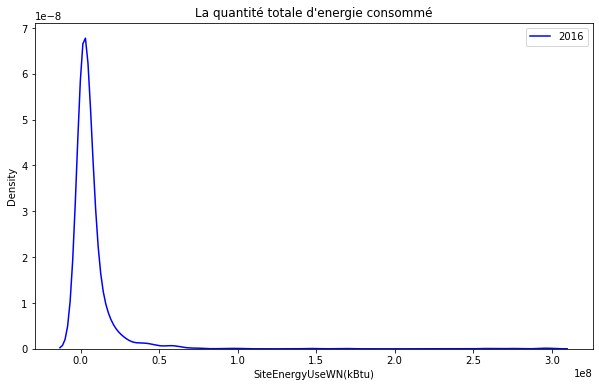

In [76]:
plt.figure(figsize=(10,6))
plt.title("La quantité totale d'energie consommé")
sns.kdeplot(filtered['SiteEnergyUseWN(kBtu)'], label='2016', color= 'blue')

plt.legend()
plt.show()

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='SiteEnergyUseWN(kBtu)'>

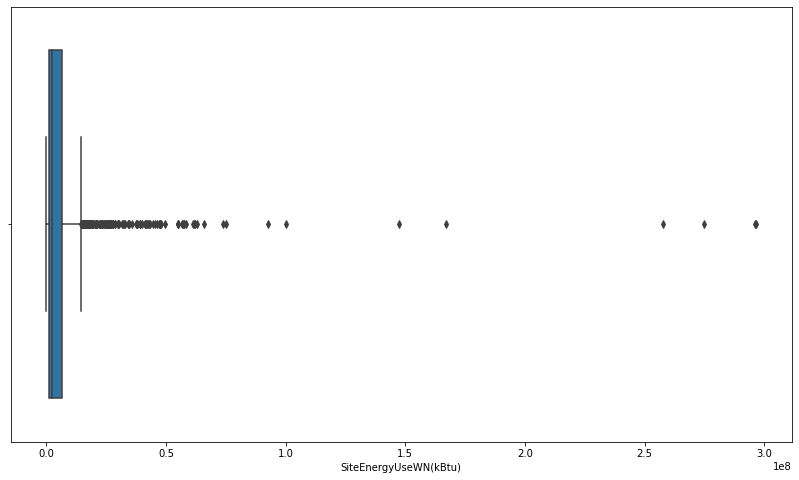

In [77]:
plt.figure(figsize=(14,8))
sns.boxplot(filtered['SiteEnergyUseWN(kBtu)'])

### Observer la valeur maximal de la target site enrgy use

In [78]:
filtered['SiteEnergyUseWN(kBtu)'].describe()

count    1.418000e+03
mean     7.214231e+06
std      1.864833e+07
min      0.000000e+00
25%      1.269811e+06
50%      2.624397e+06
75%      6.652132e+06
max      2.966717e+08
Name: SiteEnergyUseWN(kBtu), dtype: float64

In [79]:
max_value = filtered['SiteEnergyUseWN(kBtu)'].max()
df_max_site_energy = filtered[filtered['SiteEnergyUseWN(kBtu)'] == max_value]


In [80]:
df_max_site_energy['PrimaryPropertyType']

170    Hospital
Name: PrimaryPropertyType, dtype: object

In [81]:
filtered.PrimaryPropertyType.value_counts()

Small- and Mid-Sized Office    275
Other                          228
Warehouse                      178
Large Office                   137
Retail Store                    84
Mixed Use Property              81
Worship Facility                68
Hotel                           67
Distribution Center             52
K-12 School                     45
Supermarket / Grocery Store     38
Medical Office                  37
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           19
University                      18
Refrigerated Warehouse          12
Hospital                        10
Restaurant                      10
Laboratory                       9
Low-Rise Multifamily             1
Name: PrimaryPropertyType, dtype: int64



 **SiteEUIWN(kBtu/sf)** (La quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie par surface)  

In [82]:
filtered['SiteEUIWN(kBtu/sf)'].isnull().sum()

0

In [83]:
filtered['SiteEUIWN(kBtu/sf)'].describe()

count    1418.000000
mean       76.510155
std        76.828449
min         0.000000
25%        36.099998
50%        55.500000
75%        87.225002
max       834.400024
Name: SiteEUIWN(kBtu/sf), dtype: float64

Nous n'avons pas de valeurs négative pour cette target

divide by zero encountered in log


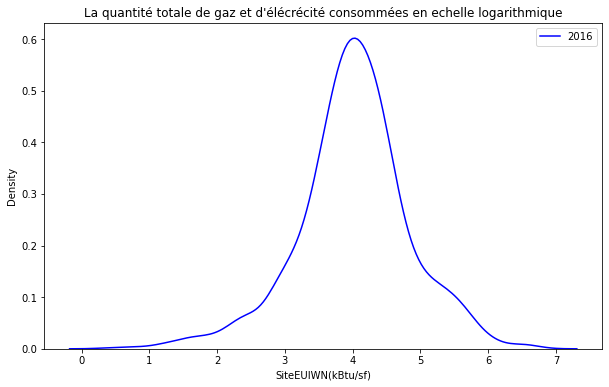

In [84]:
plt.figure(figsize=(10,6))
plt.title("La quantité totale de gaz et d'élécrécité consommées en echelle logarithmique")
sns.kdeplot(np.log(filtered['SiteEUIWN(kBtu/sf)']), label='2016', color= 'blue')

plt.legend()
plt.show()

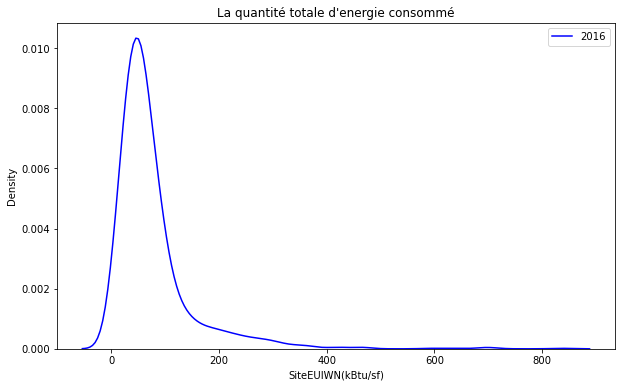

In [85]:
plt.figure(figsize=(10,6))
plt.title("La quantité totale d'energie consommé")
sns.kdeplot(filtered['SiteEUIWN(kBtu/sf)'], label='2016', color= 'blue')

plt.legend()
plt.show()

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0.5, 1.0, "La quantité totale d'energie consommé")

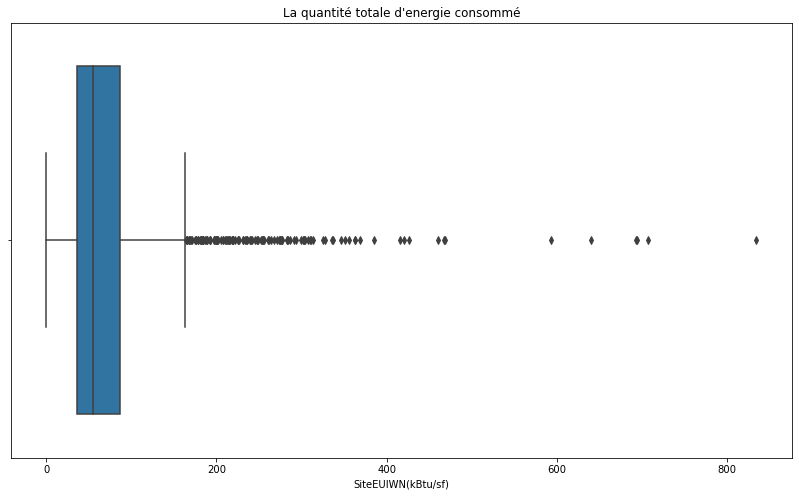

In [86]:
plt.figure(figsize=(14,8))
sns.boxplot(filtered['SiteEUIWN(kBtu/sf)'])
plt.title("La quantité totale d'energie consommé")

### Observer la valeur maximal de la target site enrgy use s/f

In [87]:

max_value = filtered['SiteEUIWN(kBtu/sf)'].max()
df_max_site_energy = filtered[filtered['SiteEUIWN(kBtu/sf)'] == max_value]


In [88]:
df_max_site_energy['PrimaryPropertyType']

240    Other
Name: PrimaryPropertyType, dtype: object

In [89]:
filtered.PrimaryPropertyType.value_counts()

Small- and Mid-Sized Office    275
Other                          228
Warehouse                      178
Large Office                   137
Retail Store                    84
Mixed Use Property              81
Worship Facility                68
Hotel                           67
Distribution Center             52
K-12 School                     45
Supermarket / Grocery Store     38
Medical Office                  37
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           19
University                      18
Refrigerated Warehouse          12
Hospital                        10
Restaurant                      10
Laboratory                       9
Low-Rise Multifamily             1
Name: PrimaryPropertyType, dtype: int64

Nous allons utiliser cette target pour la prediction car elle est divisé par la surface est donc nous avons des valeurs moins   extrême comparées à la SiteEnergyUseWN(kBtu) 

## 2. La target  TotalGHGEmissions

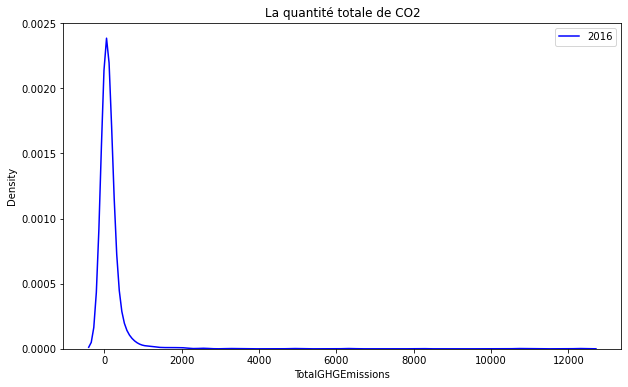

In [90]:
plt.figure(figsize=(10,6))
plt.title("La quantité totale de CO2")
sns.kdeplot(filtered['TotalGHGEmissions'], label='2016', color= 'blue')

plt.legend()
plt.show()

invalid value encountered in log


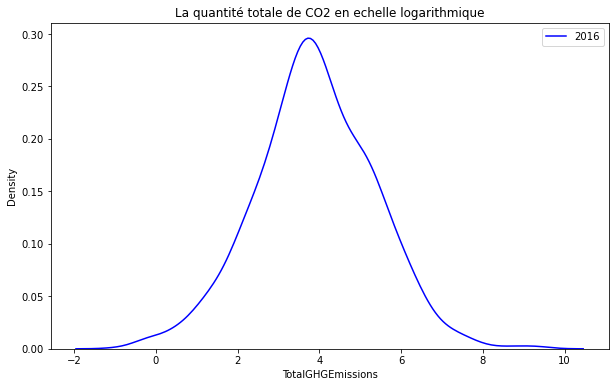

In [91]:
plt.figure(figsize=(10,6))
plt.title("La quantité totale de CO2 en echelle logarithmique")
sns.kdeplot(np.log(filtered['TotalGHGEmissions']), label='2016', color= 'blue')

plt.legend()
plt.show()

<AxesSubplot:>

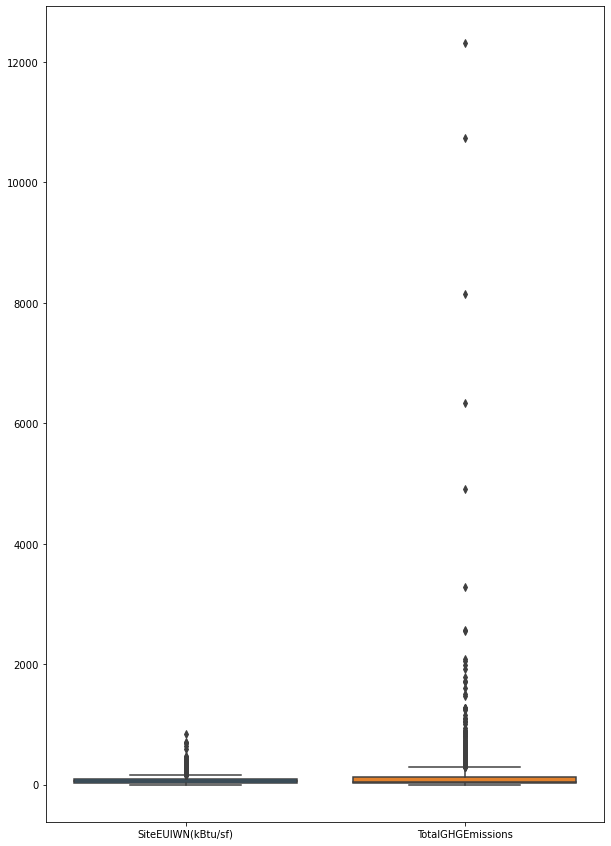

In [92]:
plt.figure(figsize = (10,15))
sns.boxplot(data = filtered[['SiteEUIWN(kBtu/sf)','TotalGHGEmissions']])


### Observer la valeur maximal de la target total CO2

In [93]:
filtered['TotalGHGEmissions'].max()

12307.16

In [94]:
# Filtering rows with the special value in the 'column_name' column
max_value_co2 = filtered['TotalGHGEmissions'].max()
df_max_total_co2 = filtered[filtered['TotalGHGEmissions'] == max_value_co2]


In [95]:
df_max_total_co2['PrimaryPropertyType']

618    Hospital
Name: PrimaryPropertyType, dtype: object

In [96]:
filtered.PrimaryPropertyType.value_counts()

Small- and Mid-Sized Office    275
Other                          228
Warehouse                      178
Large Office                   137
Retail Store                    84
Mixed Use Property              81
Worship Facility                68
Hotel                           67
Distribution Center             52
K-12 School                     45
Supermarket / Grocery Store     38
Medical Office                  37
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           19
University                      18
Refrigerated Warehouse          12
Hospital                        10
Restaurant                      10
Laboratory                       9
Low-Rise Multifamily             1
Name: PrimaryPropertyType, dtype: int64

  ## Supprimer la valeur negative dans les deux target ainsi que les valeurs nulles dans l'énergie

In [97]:
filtered = filtered[(filtered['TotalGHGEmissions'] >= 0) &(filtered['SiteEUIWN(kBtu/sf)'] > 0)]


In [98]:
filtered[['TotalGHGEmissions','SiteEUIWN(kBtu/sf)']].describe()

TotalGHGEmissions  SiteEUIWN(kBtu/sf)
count        1409.000000         1409.000000
mean          158.356182           76.995316
std           581.475138           76.832367
min             0.400000            1.500000
25%            19.770000           36.599998
50%            47.080000           55.900002
75%           130.320000           87.300003
max         12307.160000          834.400024

## Observer la relation entre les target et les features

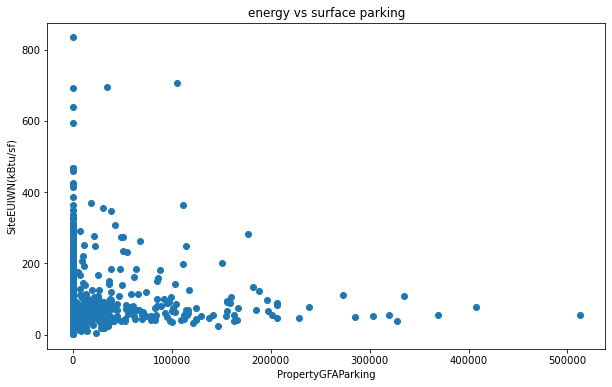

In [99]:
plt.figure(figsize = (10,6))
plt.scatter(filtered['PropertyGFAParking'], filtered['SiteEUIWN(kBtu/sf)'])
plt.xlabel('PropertyGFAParking')
plt.ylabel('SiteEUIWN(kBtu/sf)')
plt.title('energy vs surface parking')

# Afficher le scatter plot
plt.show()

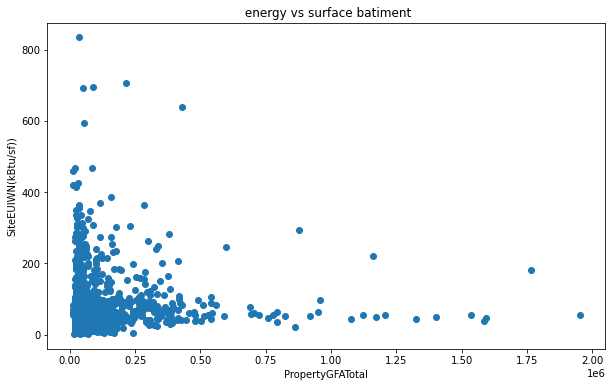

In [100]:
plt.figure(figsize = (10,6))
plt.scatter(filtered['PropertyGFATotal'], filtered['SiteEUIWN(kBtu/sf)'])
plt.xlabel('PropertyGFATotal')
plt.ylabel('SiteEUIWN(kBtu/sf))')
plt.title(' energy vs surface batiment')

# Afficher le scatter plot
plt.show()

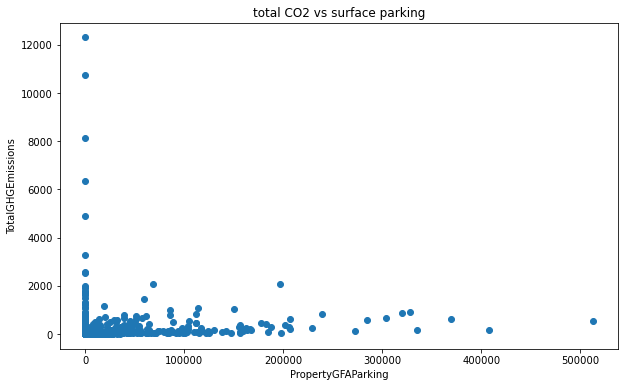

In [101]:
plt.figure(figsize = (10,6))
plt.scatter(filtered['PropertyGFAParking'], filtered['TotalGHGEmissions'])
plt.xlabel('PropertyGFAParking')
plt.ylabel('TotalGHGEmissions')
plt.title('total CO2 vs surface parking')

# Afficher le scatter plot
plt.show()

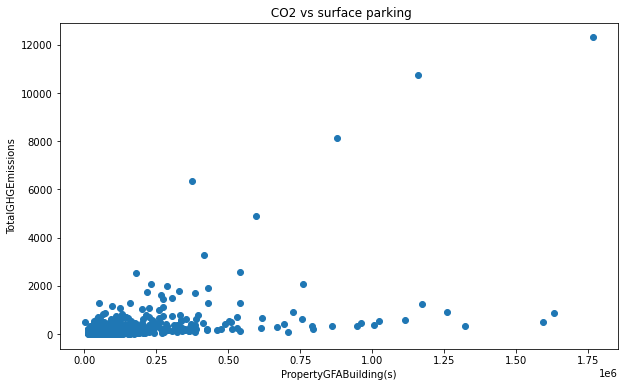

In [102]:
plt.figure(figsize = (10,6))
plt.scatter(filtered['PropertyGFABuilding(s)'], filtered['TotalGHGEmissions'])
plt.xlabel('PropertyGFABuilding(s)')
plt.ylabel('TotalGHGEmissions')
plt.title(' CO2 vs surface parking')

# Afficher le scatter plot
plt.show()

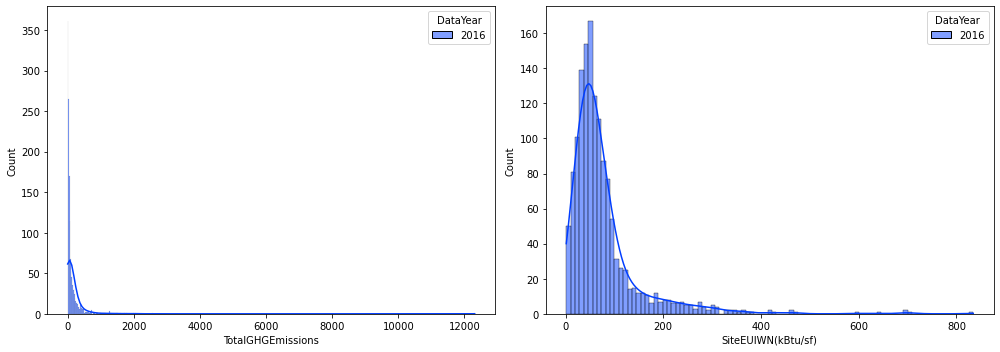

In [103]:
f, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(data=filtered, x="TotalGHGEmissions", hue="DataYear", kde=True, palette='bright', ax=axs[0])
sns.histplot(data=filtered, x="SiteEUIWN(kBtu/sf)", hue="DataYear", kde=True, palette='bright', ax=axs[1])
f.tight_layout()

## Colonne SiteEnergyUse(kBtu) et la colonne steam

Observer si la colonne SteamUse(kBtu)a été utilisé pour calculer le SiteEnergyUse(kBtu)

In [104]:
# observer les données ou la colonne steam est superieur au total consommé ou egale
data_steam = filtered[filtered['SteamUse(kBtu)'] >= filtered['SiteEnergyUse(kBtu)']]

In [105]:
data_steam.shape

(0, 45)

In [106]:
# Filtrer les lignes où la somme de deux colonnes est egale au total
filtered_elec_gaz = filtered[filtered["Electricity(kBtu)"] + filtered["NaturalGas(kBtu)"] == filtered["SiteEnergyUse(kBtu)"]]

In [107]:
filtered_elec_gaz[['Electricity(kBtu)','NaturalGas(kBtu)','SiteEnergyUse(kBtu)']].shape

(211, 3)

###  Observer les possibilitées 

1.

In [108]:
filtered_steam = filtered[(filtered["Electricity(kBtu)"] + filtered["NaturalGas(kBtu)"]  + filtered['SteamUse(kBtu)']) == filtered["SiteEnergyUse(kBtu)"]]

In [109]:
filtered_steam.shape

(217, 45)

In [110]:
# Filtrer les lignes où la somme de 3 colonnes est diffente au total
filtered_steam_two = filtered[(filtered["Electricity(kBtu)"] + filtered["NaturalGas(kBtu)"]  + filtered['SteamUse(kBtu)']) != filtered["SiteEnergyUse(kBtu)"]]

In [111]:
filtered_steam_two.shape

(1192, 45)

In [112]:
filtered_steam_two[['Electricity(kBtu)','NaturalGas(kBtu)','SteamUse(kBtu)','SiteEnergyUseWN(kBtu)']].describe()

Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
count       1.192000e+03      1.192000e+03    1.192000e+03   
mean        5.405737e+06      1.547365e+06    5.744888e+05   
std         1.375676e+07      5.749674e+06    5.983134e+06   
min         3.000000e+00      0.000000e+00    0.000000e+00   
25%         6.883495e+05      0.000000e+00    0.000000e+00   
50%         1.525814e+06      3.912160e+05    0.000000e+00   
75%         4.994184e+06      1.177422e+06    0.000000e+00   
max         2.745325e+08      1.381912e+08    1.349435e+08   

       SiteEnergyUseWN(kBtu)  
count           1.192000e+03  
mean            7.722414e+06  
std             2.017470e+07  
min             5.811420e+04  
25%             1.259279e+06  
50%             2.468669e+06  
75%             6.880045e+06  
max             2.966717e+08

In [113]:
# Définir une fonction personnalisée pour vérifier la condition avec une tolérance 100
def check_addition_two(row):
    return abs(row['Electricity(kBtu)'] + row['NaturalGas(kBtu)'] - row['SiteEnergyUse(kBtu)']) >= 100 

In [114]:
# Appliquer la fonction à chaque ligne du DataFrame
filtered['verification_two'] = filtered.apply(check_addition_two, axis=1)

In [115]:
# Afficher les lignes qui ne satisfont pas la condition
sans_conditions = filtered[~filtered['verification_two']]

In [116]:
sans_conditions.shape

(1303, 46)

2.

In [117]:
# Définir une fonction personnalisée pour vérifier la condition avec une tolérance 5
def check_addition(row):
    return abs((row['Electricity(kBtu)'] + row['NaturalGas(kBtu)'] + row['SteamUse(kBtu)']) - row['SiteEnergyUse(kBtu)']) >= 100 

In [118]:
# Appliquer la fonction à chaque ligne du DataFrame
filtered['verification'] = filtered.apply(check_addition, axis=1)

In [119]:
# Afficher les lignes qui ne satisfont pas la condition
lignes_non_verifiees = filtered[~filtered['verification']]
lignes_non_verifiees.shape

(1389, 47)

### Les resultats

In [120]:
 filtered['steam_elec_gaz'] = filtered["Electricity(kBtu)"] + filtered["NaturalGas(kBtu)"] + filtered['SteamUse(kBtu)']

In [121]:
filtered[['SiteEnergyUse(kBtu)','steam_elec_gaz']].describe()

SiteEnergyUse(kBtu)  steam_elec_gaz
count         1.409000e+03    1.409000e+03
mean          7.085225e+06    7.064036e+06
std           1.852093e+07    1.850187e+07
min           5.713320e+04    5.713300e+04
25%           1.208029e+06    1.208029e+06
50%           2.485521e+06    2.491238e+06
75%           6.461937e+06    6.461936e+06
max           2.930908e+08    2.930908e+08

<AxesSubplot:>

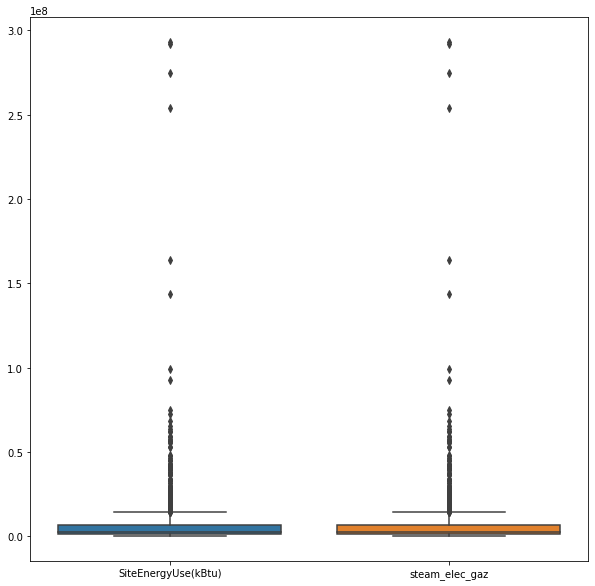

In [122]:
plt.figure(figsize = (10,10))
sns.boxplot(data = filtered[['SiteEnergyUse(kBtu)','steam_elec_gaz']])

Conclusion :Apres toutes ces verification la colonne steam est bien utilisé pour calculer l'énergie total

## Suppprimer les Colonnes que nous n'avons pas besoins pour la modelisation

In [124]:
filtered.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus', 'Outlier',
       'TotalGHG

In [125]:
columns_to_drop = ['OSEBuildingID', 'DataYear', 'BuildingType',
                   'PropertyName', 'Address', 'City', 'State', 'ZipCode',
                   'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
                   'Latitude', 'Longitude', 'NumberofBuildings',
                   'ListOfAllPropertyUseTypes',
                   'YearsENERGYSTARCertified', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                   'DefaultData', 'ComplianceStatus', 'Outlier',
                   'verification_two','verification','GHGEmissionsIntensity',
                   'NaturalGas(therms)']

In [126]:
df_clean = filtered.drop(columns_to_drop, axis = 1)

In [127]:
df_clean.isnull().sum()

PrimaryPropertyType                   0
Neighborhood                          0
YearBuilt                             0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
LargestPropertyUseType                4
LargestPropertyUseTypeGFA             4
SecondLargestPropertyUseType        687
SecondLargestPropertyUseTypeGFA     687
ThirdLargestPropertyUseType        1174
ThirdLargestPropertyUseTypeGFA     1174
ENERGYSTARScore                     487
SiteEUI(kBtu/sf)                      0
SiteEUIWN(kBtu/sf)                    0
SiteEnergyUse(kBtu)                   0
SiteEnergyUseWN(kBtu)                 0
SteamUse(kBtu)                        0
Electricity(kWh)                      0
Electricity(kBtu)                     0
NaturalGas(kBtu)                      0
TotalGHGEmissions                     0
steam_elec_gaz                        0
dtype: int64

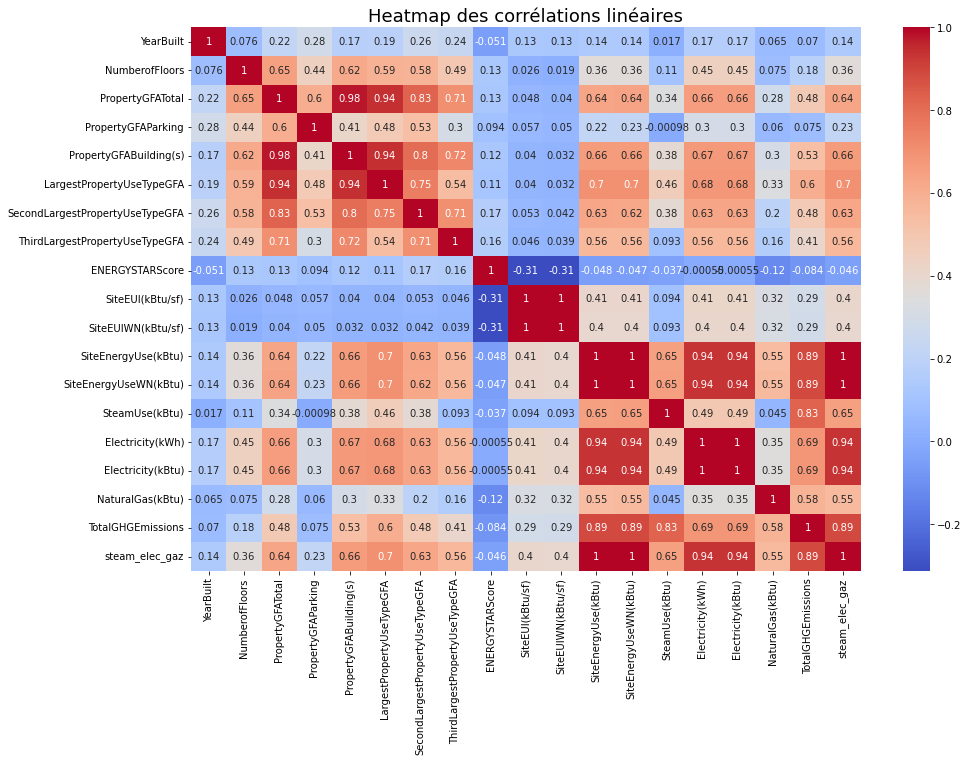

In [130]:
corr = df_clean.corr()

mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Heatmap des corrélations linéaires", fontsize = 18)
plt.show()

In [131]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1409 entries, 0 to 3375
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PrimaryPropertyType              1409 non-null   object 
 1   Neighborhood                     1409 non-null   object 
 2   YearBuilt                        1409 non-null   int64  
 3   NumberofFloors                   1409 non-null   int64  
 4   PropertyGFATotal                 1409 non-null   int64  
 5   PropertyGFAParking               1409 non-null   int64  
 6   PropertyGFABuilding(s)           1409 non-null   int64  
 7   LargestPropertyUseType           1405 non-null   object 
 8   LargestPropertyUseTypeGFA        1405 non-null   float64
 9   SecondLargestPropertyUseType     722 non-null    object 
 10  SecondLargestPropertyUseTypeGFA  722 non-null    float64
 11  ThirdLargestPropertyUseType      235 non-null    object 
 12  ThirdLargestProperty

## Creer un fichier csv pour la partie modelisation

In [262]:
df_clean.to_csv('p4_data.csv', index = False)

<AxesSubplot:>

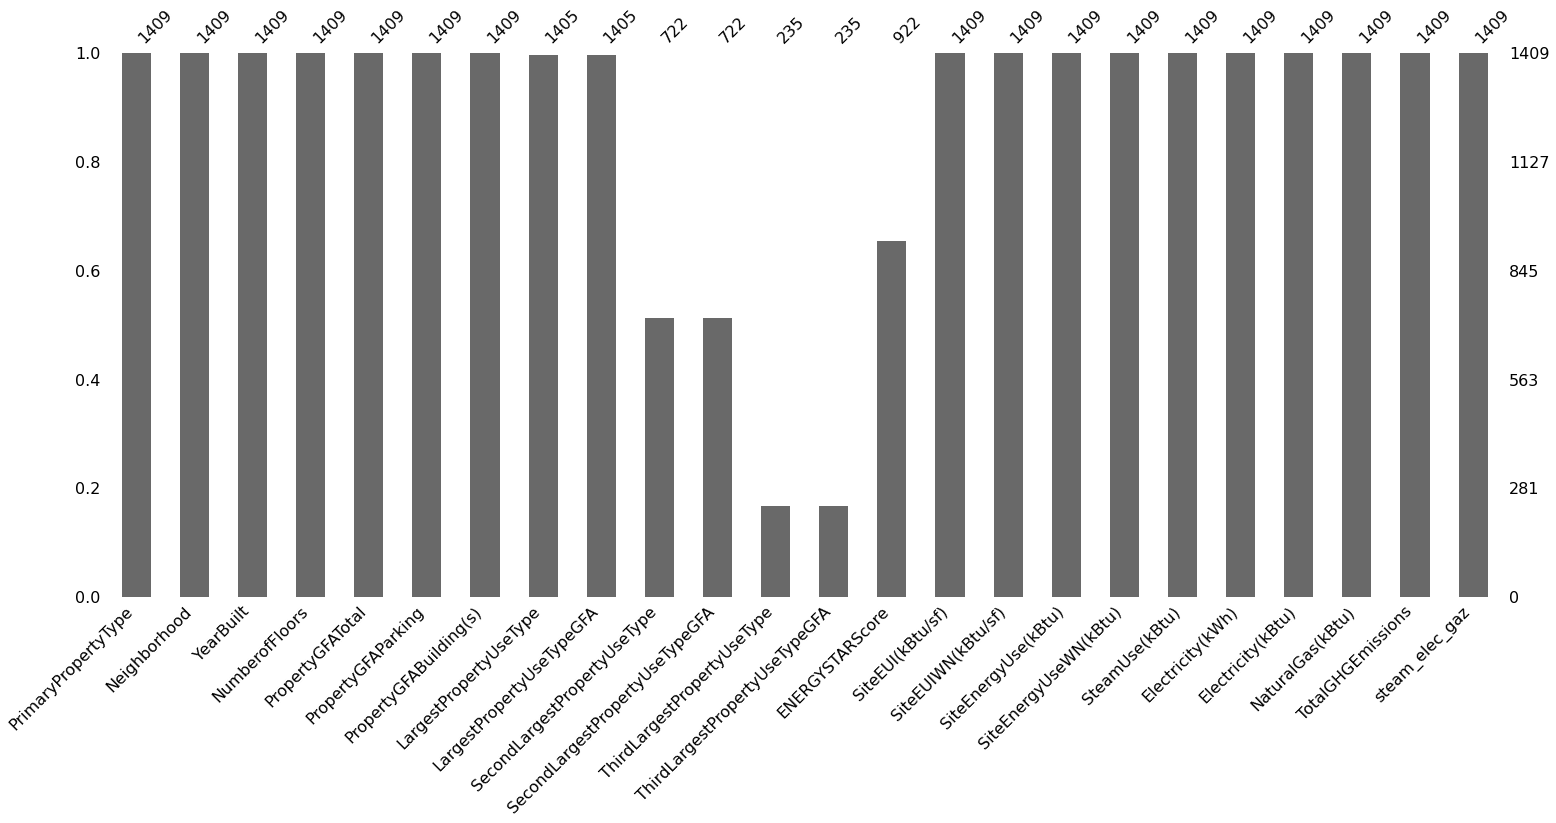

In [367]:
import missingno as msno


# Barre de visualisation
msno.bar(df_clean)
